In [61]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
import time

# create lstm models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

# hyperparameter tuning
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, Callback

# 1-Load Data

In [149]:
# load interim data set
data_set = pd.read_csv('../data/interim/international-airline-passengers.csv')
univariate_data_set = data_set["passenger_number"]
univariate_data_set

0      112.0
1      118.0
2      132.0
3      129.0
4      121.0
       ...  
139    606.0
140    508.0
141    461.0
142    390.0
143    432.0
Name: passenger_number, Length: 144, dtype: float64

In [16]:
univariate_array = univariate_data_set.values
univariate_array

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

# 2-Normalize Data

In [19]:
univariate_array_reshaped = univariate_array.reshape(-1, 1)
univariate_array_reshaped

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.],
       [104.],
       [118.],
       [115.],
       [126.],
       [141.],
       [135.],
       [125.],
       [149.],
       [170.],
       [170.],
       [158.],
       [133.],
       [114.],
       [140.],
       [145.],
       [150.],
       [178.],
       [163.],
       [172.],
       [178.],
       [199.],
       [199.],
       [184.],
       [162.],
       [146.],
       [166.],
       [171.],
       [180.],
       [193.],
       [181.],
       [183.],
       [218.],
       [230.],
       [242.],
       [209.],
       [191.],
       [172.],
       [194.],
       [196.],
       [196.],
       [236.],
       [235.],
       [229.],
       [243.],
       [264.],
       [272.],
       [237.],
       [211.],
       [180.],
       [201.],
       [204.],
       [188.],
       [235.],
       [227.],
       [234.],
       [264.],
       [30

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_univariate_array = scaler.fit_transform(univariate_array_reshaped)

# 3-Perform Train (70%), Validation (18%), Test Split (12%)

In [51]:
train_size = int(len(normalized_univariate_array) * 0.7)
validation_size = int(len(normalized_univariate_array) * 0.18)
test_size = len(normalized_univariate_array) - train_size - validation_size
train_set, validation_set, test_set = normalized_univariate_array[0:train_size,:], normalized_univariate_array[train_size:train_size+validation_size,:], normalized_univariate_array[train_size+validation_size:len(normalized_univariate_array),:]
print(f"Training set: {len(train_set)}, validation set: {len(validation_set)}, test set: {len(test_set)}")

Training set: 100, validation set: 25, test set: 19


# 4-Create samples using Moving Window Technique

In [87]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix][0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [187]:
def create_samples(train_set, validation_set, test_set, input_window_size, output_window_size):
    train_samples = split_sequence(train_set, input_window_size, output_window_size)
    val_samples = split_sequence(validation_set, input_window_size, output_window_size)
    test_samples = split_sequence(test_set, input_window_size, output_window_size)

    print(f"Number of training samples: {len(train_samples[0])}, validation samples: {len(val_samples[0])}, test samples: {len(test_samples[0])}")
    return train_samples, val_samples, test_samples

## Let's set size of the input window width to 12, becuase of the strong yearly seasonality

In [164]:
input_window_size = 12
output_window_size = 1

train_samples, val_samples, test_samples = create_samples(train_set, validation_set, test_set, input_window_size, output_window_size)

Number of training samples: 88, validation samples: 13, test samples: 7


In [165]:
train_samples

(array([[[0.01544402],
         [0.02702703],
         [0.05405405],
         ...,
         [0.02895753],
         [0.        ],
         [0.02702703]],
 
        [[0.02702703],
         [0.05405405],
         [0.04826255],
         ...,
         [0.        ],
         [0.02702703],
         [0.02123552]],
 
        [[0.05405405],
         [0.04826255],
         [0.03281853],
         ...,
         [0.02702703],
         [0.02123552],
         [0.04247104]],
 
        ...,
 
        [[0.33397683],
         [0.41119691],
         [0.4034749 ],
         ...,
         [0.32239382],
         [0.38996139],
         [0.40733591]],
 
        [[0.41119691],
         [0.4034749 ],
         [0.41312741],
         ...,
         [0.38996139],
         [0.40733591],
         [0.38030888]],
 
        [[0.4034749 ],
         [0.41312741],
         [0.52123552],
         ...,
         [0.40733591],
         [0.38030888],
         [0.48648649]]]),
 array([[0.02123552],
        [0.04247104],
        [0.

# 5-Network Architecture

In [167]:
def build_model(hp):
    model = Sequential()
    # input LSTM layer
    model.add(LSTM(hp.Int("input_units", min_value=5, max_value=50, step=3),
                   activation='relu', input_shape=(input_window_size, 1), name="lstm"))
    
    # dense hidden layers with dropouts
    for i in range(hp.Int("n_layers", 0,2)):
        model.add(Dense(hp.Int(f"dense_{i}_units", min_value=5, max_value=50, step=3),
                        activation='relu', name=f"hidden_{i}"))
        for j in range(hp.Int("dropout_layers", 0, 1)):
            model.add(Dropout(hp.Choice(f"drop_rate_{j}", values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), name=f"dropout_{i}{j}"))
    
    # dense output layer
    model.add(Dense(1, name="output"))
    model.compile(loss='mean_squared_error' , optimizer=Adam(learning_rate=
            hp.Choice("learning_rate",values=[1e-2, 1e-3, 1e-4])), metrics=[metrics.mae])
    return model

In [168]:
approach = "univariate"

# training & hyperparameter tuning
LOG_DIR = f"{int((time.time()))}"

tuner = RandomSearch(
        build_model,
        objective="val_mean_absolute_error", # evtl. RMSE
        max_trials= 5,
        executions_per_trial=3,
        directory='one_step_univariate/tuning_logs',
        project_name=LOG_DIR
    )
    
tuner.search(
    x=train_samples[0],
    y=train_samples[1],
    epochs=100,
    batch_size=32,
    validation_data=(val_samples[0], val_samples[1]),
    callbacks=[EarlyStopping('val_loss', patience=5)])
    
# get best model
model = tuner.get_best_models(num_models=1)[0]
model.save(f"../models/{approach}_{input_window_size}")

Train on 88 samples, validate on 13 samples
Epoch 1/100
88/88 [==============================] - ETA: 1s - loss: 0.1144 - mean_absolute_error: 0.295 - 1s 11ms/sample - loss: 0.0917 - mean_absolute_error: 0.2654 - val_loss: 0.3669 - val_mean_absolute_error: 0.5960
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.0877 - mean_absolute_error: 0.268 - 0s 493us/sample - loss: 0.0844 - mean_absolute_error: 0.2529 - val_loss: 0.3484 - val_mean_absolute_error: 0.5802
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.0911 - mean_absolute_error: 0.257 - 0s 438us/sample - loss: 0.0784 - mean_absolute_error: 0.2424 - val_loss: 0.3303 - val_mean_absolute_error: 0.5644
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.0742 - mean_absolute_error: 0.237 - 0s 375us/sample - loss: 0.0736 - mean_absolute_error: 0.2346 - val_loss: 0.3134 - val_mean_absolute_error: 0.5492
Epoch 5/100
88/88 [==============================] - ETA: 0s - loss: 0.06

Epoch 34/100
88/88 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.080 - 0s 355us/sample - loss: 0.0093 - mean_absolute_error: 0.0771 - val_loss: 0.0523 - val_mean_absolute_error: 0.2002
Epoch 35/100
88/88 [==============================] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.079 - 0s 389us/sample - loss: 0.0085 - mean_absolute_error: 0.0737 - val_loss: 0.0438 - val_mean_absolute_error: 0.1775
Epoch 36/100
88/88 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.068 - 0s 351us/sample - loss: 0.0078 - mean_absolute_error: 0.0716 - val_loss: 0.0361 - val_mean_absolute_error: 0.1575
Epoch 37/100
88/88 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.073 - 0s 327us/sample - loss: 0.0073 - mean_absolute_error: 0.0695 - val_loss: 0.0300 - val_mean_absolute_error: 0.1392
Epoch 38/100
88/88 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.056 - 0s 3

Epoch 20/100
88/88 [==============================] - ETA: 0s - loss: 0.0245 - mean_absolute_error: 0.118 - 0s 251us/sample - loss: 0.0317 - mean_absolute_error: 0.1380 - val_loss: 0.1802 - val_mean_absolute_error: 0.4101
Epoch 21/100
88/88 [==============================] - ETA: 0s - loss: 0.0335 - mean_absolute_error: 0.144 - 0s 252us/sample - loss: 0.0293 - mean_absolute_error: 0.1314 - val_loss: 0.1695 - val_mean_absolute_error: 0.3968
Epoch 22/100
88/88 [==============================] - ETA: 0s - loss: 0.0197 - mean_absolute_error: 0.110 - 0s 229us/sample - loss: 0.0267 - mean_absolute_error: 0.1247 - val_loss: 0.1586 - val_mean_absolute_error: 0.3828
Epoch 23/100
88/88 [==============================] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.144 - 0s 234us/sample - loss: 0.0245 - mean_absolute_error: 0.1191 - val_loss: 0.1475 - val_mean_absolute_error: 0.3679
Epoch 24/100
88/88 [==============================] - ETA: 0s - loss: 0.0247 - mean_absolute_error: 0.122 - 0s 2

Epoch 57/100
88/88 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.071 - 0s 247us/sample - loss: 0.0065 - mean_absolute_error: 0.0653 - val_loss: 0.0145 - val_mean_absolute_error: 0.0967
Epoch 58/100
88/88 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.063 - 0s 251us/sample - loss: 0.0063 - mean_absolute_error: 0.0643 - val_loss: 0.0148 - val_mean_absolute_error: 0.1012
Epoch 59/100
88/88 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.067 - 0s 240us/sample - loss: 0.0062 - mean_absolute_error: 0.0634 - val_loss: 0.0153 - val_mean_absolute_error: 0.1056
Epoch 60/100
88/88 [==============================] - ETA: 0s - loss: 0.0035 - mean_absolute_error: 0.049 - 0s 255us/sample - loss: 0.0060 - mean_absolute_error: 0.0625 - val_loss: 0.0160 - val_mean_absolute_error: 0.1103
Epoch 61/100
88/88 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.074 - 0s 2

Epoch 33/100
88/88 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.140 - 0s 257us/sample - loss: 0.0429 - mean_absolute_error: 0.1650 - val_loss: 0.2339 - val_mean_absolute_error: 0.4715
Epoch 34/100
88/88 [==============================] - ETA: 0s - loss: 0.0501 - mean_absolute_error: 0.178 - 0s 241us/sample - loss: 0.0421 - mean_absolute_error: 0.1631 - val_loss: 0.2317 - val_mean_absolute_error: 0.4691
Epoch 35/100
88/88 [==============================] - ETA: 0s - loss: 0.0429 - mean_absolute_error: 0.167 - 0s 239us/sample - loss: 0.0414 - mean_absolute_error: 0.1614 - val_loss: 0.2295 - val_mean_absolute_error: 0.4667
Epoch 36/100
88/88 [==============================] - ETA: 0s - loss: 0.0490 - mean_absolute_error: 0.168 - 0s 238us/sample - loss: 0.0407 - mean_absolute_error: 0.1597 - val_loss: 0.2273 - val_mean_absolute_error: 0.4643
Epoch 37/100
88/88 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.150 - 0s 2

Epoch 70/100
88/88 [==============================] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.133 - 0s 232us/sample - loss: 0.0250 - mean_absolute_error: 0.1213 - val_loss: 0.1697 - val_mean_absolute_error: 0.3975
Epoch 71/100
88/88 [==============================] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.144 - 0s 266us/sample - loss: 0.0248 - mean_absolute_error: 0.1207 - val_loss: 0.1684 - val_mean_absolute_error: 0.3959
Epoch 72/100
88/88 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.149 - 0s 240us/sample - loss: 0.0245 - mean_absolute_error: 0.1202 - val_loss: 0.1672 - val_mean_absolute_error: 0.3943
Epoch 73/100
88/88 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.129 - 0s 235us/sample - loss: 0.0243 - mean_absolute_error: 0.1196 - val_loss: 0.1660 - val_mean_absolute_error: 0.3928
Epoch 74/100
88/88 [==============================] - ETA: 0s - loss: 0.0207 - mean_absolute_error: 0.121 - 0s 2

Train on 88 samples, validate on 13 samples
Epoch 1/100
88/88 [==============================] - ETA: 1s - loss: 0.0851 - mean_absolute_error: 0.255 - 1s 13ms/sample - loss: 0.0737 - mean_absolute_error: 0.2359 - val_loss: 0.2761 - val_mean_absolute_error: 0.5140
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.0784 - mean_absolute_error: 0.245 - 0s 598us/sample - loss: 0.0612 - mean_absolute_error: 0.2118 - val_loss: 0.2367 - val_mean_absolute_error: 0.4741
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.0500 - mean_absolute_error: 0.187 - 0s 387us/sample - loss: 0.0494 - mean_absolute_error: 0.1864 - val_loss: 0.2069 - val_mean_absolute_error: 0.4414
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.0555 - mean_absolute_error: 0.201 - 0s 360us/sample - loss: 0.0419 - mean_absolute_error: 0.1677 - val_loss: 0.1769 - val_mean_absolute_error: 0.4059
Epoch 5/100
88/88 [==============================] - ETA: 0s - loss: 0.04

Epoch 22/100
88/88 [==============================] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.078 - 0s 376us/sample - loss: 0.0099 - mean_absolute_error: 0.0746 - val_loss: 0.0235 - val_mean_absolute_error: 0.1176
Epoch 23/100
88/88 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.062 - 0s 358us/sample - loss: 0.0082 - mean_absolute_error: 0.0686 - val_loss: 0.0227 - val_mean_absolute_error: 0.1149
Epoch 24/100
88/88 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.063 - 0s 348us/sample - loss: 0.0105 - mean_absolute_error: 0.0737 - val_loss: 0.0222 - val_mean_absolute_error: 0.1135
Epoch 25/100
88/88 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.078 - 0s 357us/sample - loss: 0.0083 - mean_absolute_error: 0.0677 - val_loss: 0.0212 - val_mean_absolute_error: 0.1112
Epoch 26/100
88/88 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.067 - 0s 3

Epoch 19/100
88/88 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.075 - 0s 291us/sample - loss: 0.0131 - mean_absolute_error: 0.0888 - val_loss: 0.0503 - val_mean_absolute_error: 0.1945
Epoch 20/100
88/88 [==============================] - ETA: 0s - loss: 0.0172 - mean_absolute_error: 0.103 - 0s 249us/sample - loss: 0.0157 - mean_absolute_error: 0.1008 - val_loss: 0.0471 - val_mean_absolute_error: 0.1859


Train on 88 samples, validate on 13 samples
Epoch 1/100
88/88 [==============================] - ETA: 1s - loss: 0.0707 - mean_absolute_error: 0.229 - 1s 10ms/sample - loss: 0.0467 - mean_absolute_error: 0.1782 - val_loss: 0.0617 - val_mean_absolute_error: 0.2206
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.072 - 0s 318us/sample - loss: 0.0111 - mean_absolute_error: 0.0887 - val_loss: 0.0139 - val_mean_absolute_error: 0.0939
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.0151 - mean_absolute_error: 0.106 - 0s 291us/sample - loss: 0.0109 - mean_absolute_error: 0.0895 - val_loss: 0.0433 - val_mean_absolute_error: 0.1760
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.057 - 0s 243us/sample - loss: 0.0091 - mean_absolute_error: 0.0728 - val_loss: 0.0483 - val_mean_absolute_error: 0.1886
Epoch 5/100
88/88 [==============================] - ETA: 0s - loss: 0.00

Train on 88 samples, validate on 13 samples
Epoch 1/100
88/88 [==============================] - ETA: 1s - loss: 0.0700 - mean_absolute_error: 0.228 - 1s 9ms/sample - loss: 0.0505 - mean_absolute_error: 0.1936 - val_loss: 0.1905 - val_mean_absolute_error: 0.4220
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.157 - 0s 322us/sample - loss: 0.0420 - mean_absolute_error: 0.1736 - val_loss: 0.1651 - val_mean_absolute_error: 0.3904
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.153 - 0s 377us/sample - loss: 0.0346 - mean_absolute_error: 0.1541 - val_loss: 0.1413 - val_mean_absolute_error: 0.3586
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.0253 - mean_absolute_error: 0.137 - 0s 332us/sample - loss: 0.0281 - mean_absolute_error: 0.1360 - val_loss: 0.1188 - val_mean_absolute_error: 0.3256
Epoch 5/100
88/88 [==============================] - ETA: 0s - loss: 0.021

88/88 [==============================] - ETA: 0s - loss: 0.0556 - mean_absolute_error: 0.200 - 0s 266us/sample - loss: 0.0671 - mean_absolute_error: 0.2237 - val_loss: 0.2741 - val_mean_absolute_error: 0.5122
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.0452 - mean_absolute_error: 0.184 - 0s 299us/sample - loss: 0.0598 - mean_absolute_error: 0.2083 - val_loss: 0.2516 - val_mean_absolute_error: 0.4896
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.0671 - mean_absolute_error: 0.218 - 0s 265us/sample - loss: 0.0531 - mean_absolute_error: 0.1929 - val_loss: 0.2300 - val_mean_absolute_error: 0.4670
Epoch 5/100
88/88 [==============================] - ETA: 0s - loss: 0.0458 - mean_absolute_error: 0.167 - 0s 270us/sample - loss: 0.0464 - mean_absolute_error: 0.1775 - val_loss: 0.2092 - val_mean_absolute_error: 0.4441
Epoch 6/100
88/88 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.162 - 0s 278us/sample - los

Train on 88 samples, validate on 13 samples
Epoch 1/100
88/88 [==============================] - ETA: 1s - loss: 0.0956 - mean_absolute_error: 0.276 - 1s 10ms/sample - loss: 0.0881 - mean_absolute_error: 0.2604 - val_loss: 0.3685 - val_mean_absolute_error: 0.5977
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.0840 - mean_absolute_error: 0.255 - 0s 314us/sample - loss: 0.0868 - mean_absolute_error: 0.2582 - val_loss: 0.3645 - val_mean_absolute_error: 0.5944
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.0892 - mean_absolute_error: 0.254 - 0s 348us/sample - loss: 0.0856 - mean_absolute_error: 0.2560 - val_loss: 0.3606 - val_mean_absolute_error: 0.5911
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.0841 - mean_absolute_error: 0.254 - 0s 306us/sample - loss: 0.0843 - mean_absolute_error: 0.2538 - val_loss: 0.3567 - val_mean_absolute_error: 0.5878
Epoch 5/100
88/88 [==============================] - ETA: 0s - loss: 0.05

Epoch 38/100
88/88 [==============================] - ETA: 0s - loss: 0.0460 - mean_absolute_error: 0.179 - 0s 317us/sample - loss: 0.0493 - mean_absolute_error: 0.1831 - val_loss: 0.2401 - val_mean_absolute_error: 0.4780
Epoch 39/100
88/88 [==============================] - ETA: 0s - loss: 0.0640 - mean_absolute_error: 0.205 - 0s 360us/sample - loss: 0.0485 - mean_absolute_error: 0.1811 - val_loss: 0.2372 - val_mean_absolute_error: 0.4750
Epoch 40/100
88/88 [==============================] - ETA: 0s - loss: 0.0544 - mean_absolute_error: 0.202 - 0s 333us/sample - loss: 0.0476 - mean_absolute_error: 0.1791 - val_loss: 0.2343 - val_mean_absolute_error: 0.4720
Epoch 41/100
88/88 [==============================] - ETA: 0s - loss: 0.0443 - mean_absolute_error: 0.176 - 0s 288us/sample - loss: 0.0467 - mean_absolute_error: 0.1769 - val_loss: 0.2315 - val_mean_absolute_error: 0.4690
Epoch 42/100
88/88 [==============================] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.151 - 0s 3

Epoch 75/100
88/88 [==============================] - ETA: 0s - loss: 0.0170 - mean_absolute_error: 0.098 - 0s 308us/sample - loss: 0.0213 - mean_absolute_error: 0.1094 - val_loss: 0.1318 - val_mean_absolute_error: 0.3465
Epoch 76/100
88/88 [==============================] - ETA: 0s - loss: 0.0285 - mean_absolute_error: 0.124 - 0s 305us/sample - loss: 0.0207 - mean_absolute_error: 0.1075 - val_loss: 0.1292 - val_mean_absolute_error: 0.3426
Epoch 77/100
88/88 [==============================] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.087 - 0s 319us/sample - loss: 0.0200 - mean_absolute_error: 0.1055 - val_loss: 0.1266 - val_mean_absolute_error: 0.3387
Epoch 78/100
88/88 [==============================] - ETA: 0s - loss: 0.0253 - mean_absolute_error: 0.117 - 0s 294us/sample - loss: 0.0195 - mean_absolute_error: 0.1038 - val_loss: 0.1239 - val_mean_absolute_error: 0.3347
Epoch 79/100
88/88 [==============================] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.090 - 0s 3

Epoch 12/100
88/88 [==============================] - ETA: 0s - loss: 0.0655 - mean_absolute_error: 0.210 - 0s 243us/sample - loss: 0.0686 - mean_absolute_error: 0.2260 - val_loss: 0.2959 - val_mean_absolute_error: 0.5332
Epoch 13/100
88/88 [==============================] - ETA: 0s - loss: 0.0596 - mean_absolute_error: 0.211 - 0s 240us/sample - loss: 0.0677 - mean_absolute_error: 0.2241 - val_loss: 0.2930 - val_mean_absolute_error: 0.5304
Epoch 14/100
88/88 [==============================] - ETA: 0s - loss: 0.0791 - mean_absolute_error: 0.247 - 0s 231us/sample - loss: 0.0668 - mean_absolute_error: 0.2221 - val_loss: 0.2901 - val_mean_absolute_error: 0.5277
Epoch 15/100
88/88 [==============================] - ETA: 0s - loss: 0.0650 - mean_absolute_error: 0.217 - 0s 243us/sample - loss: 0.0658 - mean_absolute_error: 0.2202 - val_loss: 0.2872 - val_mean_absolute_error: 0.5249
Epoch 16/100
88/88 [==============================] - ETA: 0s - loss: 0.0602 - mean_absolute_error: 0.212 - 0s 2

Epoch 49/100
88/88 [==============================] - ETA: 0s - loss: 0.0451 - mean_absolute_error: 0.170 - 0s 233us/sample - loss: 0.0356 - mean_absolute_error: 0.1500 - val_loss: 0.1868 - val_mean_absolute_error: 0.4180
Epoch 50/100
88/88 [==============================] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.140 - 0s 244us/sample - loss: 0.0348 - mean_absolute_error: 0.1478 - val_loss: 0.1838 - val_mean_absolute_error: 0.4145
Epoch 51/100
88/88 [==============================] - ETA: 0s - loss: 0.0198 - mean_absolute_error: 0.112 - 0s 229us/sample - loss: 0.0339 - mean_absolute_error: 0.1457 - val_loss: 0.1810 - val_mean_absolute_error: 0.4110
Epoch 52/100
88/88 [==============================] - ETA: 0s - loss: 0.0444 - mean_absolute_error: 0.173 - 0s 253us/sample - loss: 0.0332 - mean_absolute_error: 0.1437 - val_loss: 0.1780 - val_mean_absolute_error: 0.4073
Epoch 53/100
88/88 [==============================] - ETA: 0s - loss: 0.0384 - mean_absolute_error: 0.147 - 0s 2

Epoch 86/100
88/88 [==============================] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.092 - 0s 276us/sample - loss: 0.0122 - mean_absolute_error: 0.0861 - val_loss: 0.0799 - val_mean_absolute_error: 0.2606
Epoch 87/100
88/88 [==============================] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.086 - 0s 248us/sample - loss: 0.0119 - mean_absolute_error: 0.0854 - val_loss: 0.0776 - val_mean_absolute_error: 0.2562
Epoch 88/100
88/88 [==============================] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.088 - 0s 242us/sample - loss: 0.0116 - mean_absolute_error: 0.0844 - val_loss: 0.0755 - val_mean_absolute_error: 0.2521
Epoch 89/100
88/88 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.079 - 0s 244us/sample - loss: 0.0114 - mean_absolute_error: 0.0838 - val_loss: 0.0735 - val_mean_absolute_error: 0.2480
Epoch 90/100
88/88 [==============================] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.091 - 0s 2

Epoch 23/100
88/88 [==============================] - ETA: 0s - loss: 0.0734 - mean_absolute_error: 0.230 - 0s 229us/sample - loss: 0.0581 - mean_absolute_error: 0.2034 - val_loss: 0.2677 - val_mean_absolute_error: 0.5061
Epoch 24/100
88/88 [==============================] - ETA: 0s - loss: 0.0457 - mean_absolute_error: 0.184 - 0s 226us/sample - loss: 0.0569 - mean_absolute_error: 0.2009 - val_loss: 0.2633 - val_mean_absolute_error: 0.5017
Epoch 25/100
88/88 [==============================] - ETA: 0s - loss: 0.0452 - mean_absolute_error: 0.169 - 0s 239us/sample - loss: 0.0557 - mean_absolute_error: 0.1982 - val_loss: 0.2590 - val_mean_absolute_error: 0.4974
Epoch 26/100
88/88 [==============================] - ETA: 0s - loss: 0.0553 - mean_absolute_error: 0.195 - 0s 233us/sample - loss: 0.0545 - mean_absolute_error: 0.1957 - val_loss: 0.2546 - val_mean_absolute_error: 0.4929
Epoch 27/100
88/88 [==============================] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.224 - 0s 2

Epoch 60/100
88/88 [==============================] - ETA: 0s - loss: 0.0241 - mean_absolute_error: 0.109 - 0s 240us/sample - loss: 0.0193 - mean_absolute_error: 0.1050 - val_loss: 0.1098 - val_mean_absolute_error: 0.3121
Epoch 61/100
88/88 [==============================] - ETA: 0s - loss: 0.0223 - mean_absolute_error: 0.120 - 0s 240us/sample - loss: 0.0186 - mean_absolute_error: 0.1026 - val_loss: 0.1059 - val_mean_absolute_error: 0.3059
Epoch 62/100
88/88 [==============================] - ETA: 0s - loss: 0.0173 - mean_absolute_error: 0.093 - 0s 242us/sample - loss: 0.0178 - mean_absolute_error: 0.1000 - val_loss: 0.1022 - val_mean_absolute_error: 0.2997
Epoch 63/100
88/88 [==============================] - ETA: 0s - loss: 0.0194 - mean_absolute_error: 0.100 - 0s 233us/sample - loss: 0.0171 - mean_absolute_error: 0.0977 - val_loss: 0.0985 - val_mean_absolute_error: 0.2934
Epoch 64/100
88/88 [==============================] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.086 - 0s 2

Epoch 97/100
88/88 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.072 - 0s 298us/sample - loss: 0.0061 - mean_absolute_error: 0.0610 - val_loss: 0.0256 - val_mean_absolute_error: 0.1232
Epoch 98/100
88/88 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.054 - 0s 287us/sample - loss: 0.0060 - mean_absolute_error: 0.0607 - val_loss: 0.0250 - val_mean_absolute_error: 0.1213
Epoch 99/100
88/88 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.050 - 0s 310us/sample - loss: 0.0060 - mean_absolute_error: 0.0605 - val_loss: 0.0244 - val_mean_absolute_error: 0.1195
Epoch 100/100
88/88 [==============================] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.051 - 0s 312us/sample - loss: 0.0059 - mean_absolute_error: 0.0603 - val_loss: 0.0239 - val_mean_absolute_error: 0.1177


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ../models/univariate_12/assets


# 6-Make &Denormalize Predictions

In [169]:
# make predictions
predictions_for_train = model.predict(train_samples[0])
predictions_for_validation = model.predict(val_samples[0])
predictions_for_test = model.predict(test_samples[0])
predictions_for_test

array([[0.6323485 ],
       [0.65607077],
       [0.69591135],
       [0.7250152 ],
       [0.72858435],
       [0.7234619 ],
       [0.70183414]], dtype=float32)

In [170]:
# invert predictions
predictions_for_train_denormalized = scaler.inverse_transform(predictions_for_train)
true_values_train = scaler.inverse_transform(train_samples[1])

predictions_for_val_denormalized = scaler.inverse_transform(predictions_for_validation)
true_values_val = scaler.inverse_transform(val_samples[1])

predictions_for_test_denormalized = scaler.inverse_transform(predictions_for_test)
true_values_test = scaler.inverse_transform(test_samples[1])

# 7-Evaluation

In [171]:
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(true_values_train, predictions_for_train_denormalized))
print('Train Score: %.2f RMSE' % (train_score))

validation_score = math.sqrt(mean_squared_error(true_values_val, predictions_for_val_denormalized))
print('Validation Score: %.2f RMSE' % (validation_score))

test_score = math.sqrt(mean_squared_error(true_values_test, predictions_for_test_denormalized))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 51.08 RMSE
Validation Score: 60.53 RMSE
Test Score: 102.00 RMSE


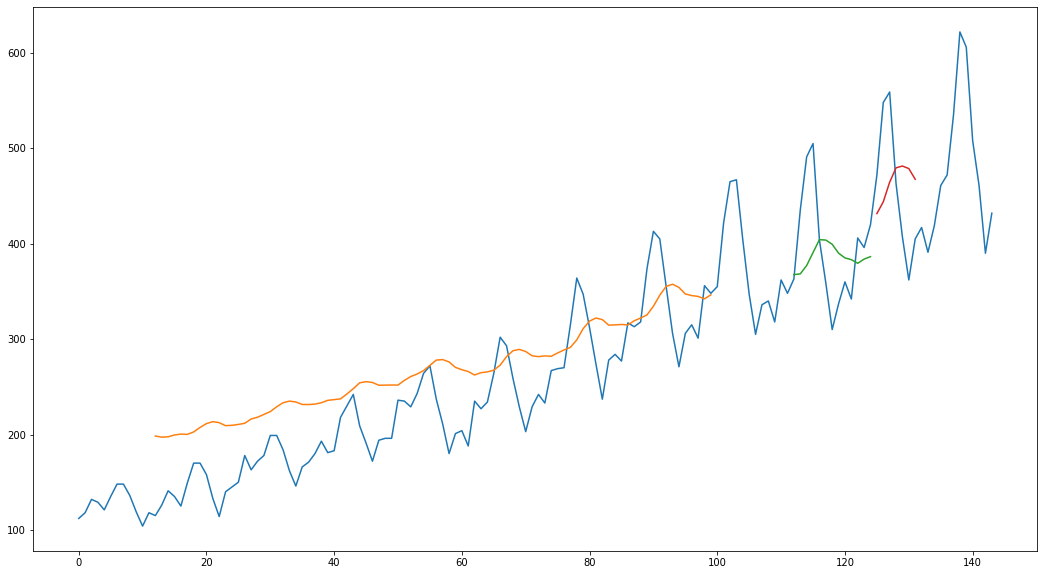

In [173]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(normalized_univariate_array)
train_predict_plot[:, :] = np.nan
# reshape in order to fill only the training examples
train_predict_plot[input_window_size:len(predictions_for_train_denormalized)+input_window_size, :] = predictions_for_train_denormalized

# shift validation predictions for plotting
validation_predict_plot = np.empty_like(normalized_univariate_array)
validation_predict_plot[:, :] = np.nan
validation_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized), :] = predictions_for_val_denormalized

# shift test predictions for plotting
test_predict_plot = np.empty_like(normalized_univariate_array)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized)+len(predictions_for_test_denormalized)] = predictions_for_test_denormalized


# plot baseline and predictions
fig = plt.figure(figsize=(18, 10))
plt.plot(scaler.inverse_transform(normalized_univariate_array))
plt.plot(train_predict_plot)
plt.plot(validation_predict_plot)
plt.plot(test_predict_plot)
plt.show()

# 8-Conclusion

### This combination of architecture and input window size performed very poor. Let's try different input window width adn then adjust the network architecture.

# 9-Further experiments

### Let's decrease the input window size to 6 months

In [178]:
input_window_size = 6
output_window_size = 1

train_samples, val_samples, test_samples = create_samples(train_set, validation_set, test_set, input_window_size, output_window_size)

Number of training samples: 94, validation samples: 19, test samples: 13


In [179]:
approach = "univariate"

# training & hyperparameter tuning
LOG_DIR = f"{int((time.time()))}"

tuner = RandomSearch(
        build_model,
        objective="val_mean_absolute_error", # evtl. RMSE
        max_trials= 5,
        executions_per_trial=3,
        directory='one_step_univariate/tuning_logs',
        project_name=LOG_DIR
    )
    
tuner.search(
    x=train_samples[0],
    y=train_samples[1],
    epochs=100,
    batch_size=32,
    validation_data=(val_samples[0], val_samples[1]),
    callbacks=[EarlyStopping('val_loss', patience=5)])
    
# get best model
model = tuner.get_best_models(num_models=1)[0]
model.save(f"../models/{approach}_{input_window_size}")

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0691 - mean_absolute_error: 0.224 - 1s 11ms/sample - loss: 0.0664 - mean_absolute_error: 0.2206 - val_loss: 0.2575 - val_mean_absolute_error: 0.4963
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0646 - mean_absolute_error: 0.212 - 0s 283us/sample - loss: 0.0658 - mean_absolute_error: 0.2194 - val_loss: 0.2558 - val_mean_absolute_error: 0.4947
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0490 - mean_absolute_error: 0.187 - 0s 326us/sample - loss: 0.0652 - mean_absolute_error: 0.2182 - val_loss: 0.2542 - val_mean_absolute_error: 0.4930
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0578 - mean_absolute_error: 0.193 - 0s 319us/sample - loss: 0.0646 - mean_absolute_error: 0.2171 - val_loss: 0.2526 - val_mean_absolute_error: 0.4913
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.05

Epoch 34/100
94/94 [==============================] - ETA: 0s - loss: 0.0743 - mean_absolute_error: 0.244 - 0s 361us/sample - loss: 0.0506 - mean_absolute_error: 0.1862 - val_loss: 0.2114 - val_mean_absolute_error: 0.4475
Epoch 35/100
94/94 [==============================] - ETA: 0s - loss: 0.0670 - mean_absolute_error: 0.222 - 0s 314us/sample - loss: 0.0502 - mean_absolute_error: 0.1852 - val_loss: 0.2102 - val_mean_absolute_error: 0.4462
Epoch 36/100
94/94 [==============================] - ETA: 0s - loss: 0.0412 - mean_absolute_error: 0.167 - 0s 273us/sample - loss: 0.0497 - mean_absolute_error: 0.1843 - val_loss: 0.2090 - val_mean_absolute_error: 0.4448
Epoch 37/100
94/94 [==============================] - ETA: 0s - loss: 0.0434 - mean_absolute_error: 0.172 - 0s 280us/sample - loss: 0.0493 - mean_absolute_error: 0.1833 - val_loss: 0.2078 - val_mean_absolute_error: 0.4435
Epoch 38/100
94/94 [==============================] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.207 - 0s 3

Epoch 71/100
94/94 [==============================] - ETA: 0s - loss: 0.0479 - mean_absolute_error: 0.181 - 0s 288us/sample - loss: 0.0357 - mean_absolute_error: 0.1497 - val_loss: 0.1669 - val_mean_absolute_error: 0.3948
Epoch 72/100
94/94 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.131 - 0s 298us/sample - loss: 0.0354 - mean_absolute_error: 0.1487 - val_loss: 0.1657 - val_mean_absolute_error: 0.3933
Epoch 73/100
94/94 [==============================] - ETA: 0s - loss: 0.0242 - mean_absolute_error: 0.111 - 0s 313us/sample - loss: 0.0350 - mean_absolute_error: 0.1477 - val_loss: 0.1645 - val_mean_absolute_error: 0.3917
Epoch 74/100
94/94 [==============================] - ETA: 0s - loss: 0.0250 - mean_absolute_error: 0.122 - 0s 301us/sample - loss: 0.0346 - mean_absolute_error: 0.1468 - val_loss: 0.1633 - val_mean_absolute_error: 0.3901
Epoch 75/100
94/94 [==============================] - ETA: 0s - loss: 0.0278 - mean_absolute_error: 0.126 - 0s 2

Epoch 8/100
94/94 [==============================] - ETA: 0s - loss: 0.0650 - mean_absolute_error: 0.216 - 0s 198us/sample - loss: 0.0836 - mean_absolute_error: 0.2470 - val_loss: 0.3334 - val_mean_absolute_error: 0.5676
Epoch 9/100
94/94 [==============================] - ETA: 0s - loss: 0.0825 - mean_absolute_error: 0.235 - 0s 207us/sample - loss: 0.0829 - mean_absolute_error: 0.2458 - val_loss: 0.3315 - val_mean_absolute_error: 0.5659
Epoch 10/100
94/94 [==============================] - ETA: 0s - loss: 0.0927 - mean_absolute_error: 0.262 - 0s 207us/sample - loss: 0.0823 - mean_absolute_error: 0.2446 - val_loss: 0.3296 - val_mean_absolute_error: 0.5643
Epoch 11/100
94/94 [==============================] - ETA: 0s - loss: 0.0760 - mean_absolute_error: 0.233 - 0s 185us/sample - loss: 0.0817 - mean_absolute_error: 0.2435 - val_loss: 0.3278 - val_mean_absolute_error: 0.5626
Epoch 12/100
94/94 [==============================] - ETA: 0s - loss: 0.0797 - mean_absolute_error: 0.238 - 0s 181

Epoch 45/100
94/94 [==============================] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.205 - 0s 179us/sample - loss: 0.0612 - mean_absolute_error: 0.2024 - val_loss: 0.2688 - val_mean_absolute_error: 0.5076
Epoch 46/100
94/94 [==============================] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.224 - 0s 228us/sample - loss: 0.0606 - mean_absolute_error: 0.2011 - val_loss: 0.2669 - val_mean_absolute_error: 0.5057
Epoch 47/100
94/94 [==============================] - ETA: 0s - loss: 0.0832 - mean_absolute_error: 0.248 - 0s 239us/sample - loss: 0.0600 - mean_absolute_error: 0.1997 - val_loss: 0.2649 - val_mean_absolute_error: 0.5037
Epoch 48/100
94/94 [==============================] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.184 - 0s 216us/sample - loss: 0.0593 - mean_absolute_error: 0.1984 - val_loss: 0.2630 - val_mean_absolute_error: 0.5018
Epoch 49/100
94/94 [==============================] - ETA: 0s - loss: 0.0755 - mean_absolute_error: 0.240 - 0s 1

Epoch 82/100
94/94 [==============================] - ETA: 0s - loss: 0.0278 - mean_absolute_error: 0.127 - 0s 217us/sample - loss: 0.0377 - mean_absolute_error: 0.1494 - val_loss: 0.1965 - val_mean_absolute_error: 0.4299
Epoch 83/100
94/94 [==============================] - ETA: 0s - loss: 0.0471 - mean_absolute_error: 0.178 - 0s 186us/sample - loss: 0.0371 - mean_absolute_error: 0.1479 - val_loss: 0.1943 - val_mean_absolute_error: 0.4273
Epoch 84/100
94/94 [==============================] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.139 - 0s 194us/sample - loss: 0.0365 - mean_absolute_error: 0.1463 - val_loss: 0.1921 - val_mean_absolute_error: 0.4247
Epoch 85/100
94/94 [==============================] - ETA: 0s - loss: 0.0476 - mean_absolute_error: 0.169 - 0s 200us/sample - loss: 0.0358 - mean_absolute_error: 0.1448 - val_loss: 0.1899 - val_mean_absolute_error: 0.4221
Epoch 86/100
94/94 [==============================] - ETA: 0s - loss: 0.0205 - mean_absolute_error: 0.113 - 0s 2

Epoch 19/100
94/94 [==============================] - ETA: 0s - loss: 0.0466 - mean_absolute_error: 0.179 - 0s 179us/sample - loss: 0.0653 - mean_absolute_error: 0.2160 - val_loss: 0.2629 - val_mean_absolute_error: 0.5015
Epoch 20/100
94/94 [==============================] - ETA: 0s - loss: 0.0712 - mean_absolute_error: 0.221 - 0s 195us/sample - loss: 0.0649 - mean_absolute_error: 0.2151 - val_loss: 0.2616 - val_mean_absolute_error: 0.5002
Epoch 21/100
94/94 [==============================] - ETA: 0s - loss: 0.0626 - mean_absolute_error: 0.206 - 0s 175us/sample - loss: 0.0645 - mean_absolute_error: 0.2142 - val_loss: 0.2603 - val_mean_absolute_error: 0.4990
Epoch 22/100
94/94 [==============================] - ETA: 0s - loss: 0.0671 - mean_absolute_error: 0.221 - 0s 180us/sample - loss: 0.0641 - mean_absolute_error: 0.2134 - val_loss: 0.2591 - val_mean_absolute_error: 0.4977
Epoch 23/100
94/94 [==============================] - ETA: 0s - loss: 0.0738 - mean_absolute_error: 0.230 - 0s 1

Epoch 56/100
94/94 [==============================] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.148 - 0s 201us/sample - loss: 0.0516 - mean_absolute_error: 0.1859 - val_loss: 0.2221 - val_mean_absolute_error: 0.4590
Epoch 57/100
94/94 [==============================] - ETA: 0s - loss: 0.0490 - mean_absolute_error: 0.190 - 0s 222us/sample - loss: 0.0513 - mean_absolute_error: 0.1851 - val_loss: 0.2211 - val_mean_absolute_error: 0.4579
Epoch 58/100
94/94 [==============================] - ETA: 0s - loss: 0.0562 - mean_absolute_error: 0.201 - 0s 204us/sample - loss: 0.0510 - mean_absolute_error: 0.1843 - val_loss: 0.2201 - val_mean_absolute_error: 0.4569
Epoch 59/100
94/94 [==============================] - ETA: 0s - loss: 0.0286 - mean_absolute_error: 0.133 - 0s 202us/sample - loss: 0.0506 - mean_absolute_error: 0.1834 - val_loss: 0.2191 - val_mean_absolute_error: 0.4558
Epoch 60/100
94/94 [==============================] - ETA: 0s - loss: 0.0475 - mean_absolute_error: 0.178 - 0s 2

Epoch 93/100
94/94 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.149 - 0s 250us/sample - loss: 0.0367 - mean_absolute_error: 0.1477 - val_loss: 0.1843 - val_mean_absolute_error: 0.4157
Epoch 94/100
94/94 [==============================] - ETA: 0s - loss: 0.0410 - mean_absolute_error: 0.146 - 0s 179us/sample - loss: 0.0361 - mean_absolute_error: 0.1463 - val_loss: 0.1832 - val_mean_absolute_error: 0.4143
Epoch 95/100
94/94 [==============================] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.147 - 0s 190us/sample - loss: 0.0356 - mean_absolute_error: 0.1450 - val_loss: 0.1820 - val_mean_absolute_error: 0.4128
Epoch 96/100
94/94 [==============================] - ETA: 0s - loss: 0.0310 - mean_absolute_error: 0.126 - 0s 172us/sample - loss: 0.0351 - mean_absolute_error: 0.1437 - val_loss: 0.1808 - val_mean_absolute_error: 0.4113
Epoch 97/100
94/94 [==============================] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.142 - 0s 1

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0503 - mean_absolute_error: 0.195 - 1s 10ms/sample - loss: 0.0537 - mean_absolute_error: 0.1967 - val_loss: 0.1912 - val_mean_absolute_error: 0.4237
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0416 - mean_absolute_error: 0.167 - 0s 270us/sample - loss: 0.0457 - mean_absolute_error: 0.1780 - val_loss: 0.1682 - val_mean_absolute_error: 0.3954
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.171 - 0s 295us/sample - loss: 0.0385 - mean_absolute_error: 0.1599 - val_loss: 0.1450 - val_mean_absolute_error: 0.3648
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.152 - 0s 268us/sample - loss: 0.0314 - mean_absolute_error: 0.1412 - val_loss: 0.1224 - val_mean_absolute_error: 0.3320
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.03

Epoch 21/100
94/94 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.061 - 0s 225us/sample - loss: 0.0071 - mean_absolute_error: 0.0664 - val_loss: 0.0286 - val_mean_absolute_error: 0.1346
Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0789 - mean_absolute_error: 0.239 - 1s 9ms/sample - loss: 0.0703 - mean_absolute_error: 0.2262 - val_loss: 0.2619 - val_mean_absolute_error: 0.5007
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0440 - mean_absolute_error: 0.180 - 0s 207us/sample - loss: 0.0621 - mean_absolute_error: 0.2102 - val_loss: 0.2401 - val_mean_absolute_error: 0.4784
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0665 - mean_absolute_error: 0.203 - 0s 204us/sample - loss: 0.0554 - mean_absolute_error: 0.1950 - val_loss: 0.2192 - val_mean_absolute_error: 0.4560
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.04

Epoch 37/100
94/94 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.049 - 0s 356us/sample - loss: 0.0037 - mean_absolute_error: 0.0474 - val_loss: 0.0138 - val_mean_absolute_error: 0.0902
Epoch 38/100
94/94 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.060 - 0s 302us/sample - loss: 0.0037 - mean_absolute_error: 0.0475 - val_loss: 0.0136 - val_mean_absolute_error: 0.0898
Epoch 39/100
94/94 [==============================] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.044 - 0s 277us/sample - loss: 0.0037 - mean_absolute_error: 0.0471 - val_loss: 0.0135 - val_mean_absolute_error: 0.0894
Epoch 40/100
94/94 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.053 - 0s 298us/sample - loss: 0.0036 - mean_absolute_error: 0.0469 - val_loss: 0.0133 - val_mean_absolute_error: 0.0891
Epoch 41/100
94/94 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.046 - 0s 2

Epoch 74/100
94/94 [==============================] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.040 - 0s 184us/sample - loss: 0.0031 - mean_absolute_error: 0.0426 - val_loss: 0.0106 - val_mean_absolute_error: 0.0796
Epoch 75/100
94/94 [==============================] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.040 - 0s 188us/sample - loss: 0.0031 - mean_absolute_error: 0.0430 - val_loss: 0.0106 - val_mean_absolute_error: 0.0799
Epoch 76/100
94/94 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.036 - 0s 190us/sample - loss: 0.0030 - mean_absolute_error: 0.0427 - val_loss: 0.0103 - val_mean_absolute_error: 0.0779
Epoch 77/100
94/94 [==============================] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.044 - 0s 313us/sample - loss: 0.0030 - mean_absolute_error: 0.0422 - val_loss: 0.0102 - val_mean_absolute_error: 0.0775
Epoch 78/100
94/94 [==============================] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.042 - 0s 2

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0793 - mean_absolute_error: 0.225 - 1s 10ms/sample - loss: 0.0752 - mean_absolute_error: 0.2343 - val_loss: 0.2825 - val_mean_absolute_error: 0.5209
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0763 - mean_absolute_error: 0.232 - 0s 294us/sample - loss: 0.0672 - mean_absolute_error: 0.2181 - val_loss: 0.2602 - val_mean_absolute_error: 0.4991
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0585 - mean_absolute_error: 0.195 - 0s 285us/sample - loss: 0.0596 - mean_absolute_error: 0.2027 - val_loss: 0.2383 - val_mean_absolute_error: 0.4766
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0574 - mean_absolute_error: 0.203 - 0s 256us/sample - loss: 0.0530 - mean_absolute_error: 0.1889 - val_loss: 0.2185 - val_mean_absolute_error: 0.4554
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.05

Epoch 38/100
94/94 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.052 - 0s 175us/sample - loss: 0.0041 - mean_absolute_error: 0.0517 - val_loss: 0.0150 - val_mean_absolute_error: 0.0941
Epoch 39/100
94/94 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.056 - 0s 321us/sample - loss: 0.0041 - mean_absolute_error: 0.0515 - val_loss: 0.0150 - val_mean_absolute_error: 0.0941
Epoch 40/100
94/94 [==============================] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.048 - 0s 174us/sample - loss: 0.0041 - mean_absolute_error: 0.0513 - val_loss: 0.0152 - val_mean_absolute_error: 0.0942
Epoch 41/100
94/94 [==============================] - ETA: 0s - loss: 0.0035 - mean_absolute_error: 0.048 - 0s 177us/sample - loss: 0.0041 - mean_absolute_error: 0.0512 - val_loss: 0.0152 - val_mean_absolute_error: 0.0942
Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss:

Epoch 12/100
94/94 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.084 - 0s 185us/sample - loss: 0.0127 - mean_absolute_error: 0.0911 - val_loss: 0.0552 - val_mean_absolute_error: 0.2059
Epoch 13/100
94/94 [==============================] - ETA: 0s - loss: 0.0120 - mean_absolute_error: 0.092 - 0s 181us/sample - loss: 0.0120 - mean_absolute_error: 0.0893 - val_loss: 0.0462 - val_mean_absolute_error: 0.1824
Epoch 14/100
94/94 [==============================] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.096 - 0s 194us/sample - loss: 0.0117 - mean_absolute_error: 0.0896 - val_loss: 0.0400 - val_mean_absolute_error: 0.1644
Epoch 15/100
94/94 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.077 - 0s 209us/sample - loss: 0.0114 - mean_absolute_error: 0.0888 - val_loss: 0.0364 - val_mean_absolute_error: 0.1545
Epoch 16/100
94/94 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.081 - 0s 1

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0744 - mean_absolute_error: 0.237 - 1s 10ms/sample - loss: 0.0526 - mean_absolute_error: 0.1877 - val_loss: 0.1337 - val_mean_absolute_error: 0.3497
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0286 - mean_absolute_error: 0.123 - 0s 263us/sample - loss: 0.0193 - mean_absolute_error: 0.1038 - val_loss: 0.0433 - val_mean_absolute_error: 0.1768
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.102 - 0s 321us/sample - loss: 0.0161 - mean_absolute_error: 0.1078 - val_loss: 0.0149 - val_mean_absolute_error: 0.0934
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.127 - 0s 182us/sample - loss: 0.0187 - mean_absolute_error: 0.1192 - val_loss: 0.0205 - val_mean_absolute_error: 0.1061
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.01

Epoch 30/100
94/94 [==============================] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.049 - 0s 264us/sample - loss: 0.0038 - mean_absolute_error: 0.0484 - val_loss: 0.0139 - val_mean_absolute_error: 0.0925
Epoch 31/100
94/94 [==============================] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.046 - 0s 262us/sample - loss: 0.0038 - mean_absolute_error: 0.0479 - val_loss: 0.0139 - val_mean_absolute_error: 0.0918
Epoch 32/100
94/94 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.059 - 0s 251us/sample - loss: 0.0037 - mean_absolute_error: 0.0480 - val_loss: 0.0129 - val_mean_absolute_error: 0.0912
Epoch 33/100
94/94 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.050 - 0s 243us/sample - loss: 0.0037 - mean_absolute_error: 0.0478 - val_loss: 0.0128 - val_mean_absolute_error: 0.0906
Epoch 34/100
94/94 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.050 - 0s 2

Epoch 7/100
94/94 [==============================] - ETA: 0s - loss: 0.0156 - mean_absolute_error: 0.095 - 0s 207us/sample - loss: 0.0114 - mean_absolute_error: 0.0815 - val_loss: 0.0443 - val_mean_absolute_error: 0.1786
Epoch 8/100
94/94 [==============================] - ETA: 0s - loss: 0.0157 - mean_absolute_error: 0.099 - 0s 194us/sample - loss: 0.0091 - mean_absolute_error: 0.0746 - val_loss: 0.0253 - val_mean_absolute_error: 0.1242


Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0859 - mean_absolute_error: 0.245 - 1s 13ms/sample - loss: 0.0701 - mean_absolute_error: 0.2267 - val_loss: 0.2701 - val_mean_absolute_error: 0.5085
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0689 - mean_absolute_error: 0.221 - 0s 386us/sample - loss: 0.0687 - mean_absolute_error: 0.2239 - val_loss: 0.2659 - val_mean_absolute_error: 0.5044
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0497 - mean_absolute_error: 0.182 - 0s 356us/sample - loss: 0.0672 - mean_absolute_error: 0.2211 - val_loss: 0.2617 - val_mean_absolute_error: 0.5002
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0703 - mean_absolute_error: 0.233 - 0s 346us/sample - loss: 0.0659 - mean_absolute_error: 0.2182 - val_loss: 0.2575 - val_mean_absolute_error: 0.4959
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.06

Epoch 38/100
94/94 [==============================] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.110 - 0s 293us/sample - loss: 0.0257 - mean_absolute_error: 0.1225 - val_loss: 0.1261 - val_mean_absolute_error: 0.3374
Epoch 39/100
94/94 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.120 - 0s 315us/sample - loss: 0.0248 - mean_absolute_error: 0.1200 - val_loss: 0.1225 - val_mean_absolute_error: 0.3321
Epoch 40/100
94/94 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.139 - 0s 275us/sample - loss: 0.0240 - mean_absolute_error: 0.1176 - val_loss: 0.1190 - val_mean_absolute_error: 0.3267
Epoch 41/100
94/94 [==============================] - ETA: 0s - loss: 0.0295 - mean_absolute_error: 0.136 - 0s 297us/sample - loss: 0.0230 - mean_absolute_error: 0.1150 - val_loss: 0.1155 - val_mean_absolute_error: 0.3213
Epoch 42/100
94/94 [==============================] - ETA: 0s - loss: 0.0194 - mean_absolute_error: 0.103 - 0s 3

Epoch 75/100
94/94 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.072 - 0s 336us/sample - loss: 0.0086 - mean_absolute_error: 0.0739 - val_loss: 0.0402 - val_mean_absolute_error: 0.1640
Epoch 76/100
94/94 [==============================] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.088 - 0s 370us/sample - loss: 0.0085 - mean_absolute_error: 0.0735 - val_loss: 0.0392 - val_mean_absolute_error: 0.1615
Epoch 77/100
94/94 [==============================] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.094 - 0s 331us/sample - loss: 0.0083 - mean_absolute_error: 0.0731 - val_loss: 0.0383 - val_mean_absolute_error: 0.1592
Epoch 78/100
94/94 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.074 - 0s 327us/sample - loss: 0.0082 - mean_absolute_error: 0.0726 - val_loss: 0.0375 - val_mean_absolute_error: 0.1572
Epoch 79/100
94/94 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.068 - 0s 3

Epoch 12/100
94/94 [==============================] - ETA: 0s - loss: 0.0506 - mean_absolute_error: 0.185 - 0s 223us/sample - loss: 0.0483 - mean_absolute_error: 0.1825 - val_loss: 0.1966 - val_mean_absolute_error: 0.4305
Epoch 13/100
94/94 [==============================] - ETA: 0s - loss: 0.0453 - mean_absolute_error: 0.166 - 0s 200us/sample - loss: 0.0471 - mean_absolute_error: 0.1796 - val_loss: 0.1929 - val_mean_absolute_error: 0.4262
Epoch 14/100
94/94 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.161 - 0s 212us/sample - loss: 0.0459 - mean_absolute_error: 0.1769 - val_loss: 0.1892 - val_mean_absolute_error: 0.4218
Epoch 15/100
94/94 [==============================] - ETA: 0s - loss: 0.0406 - mean_absolute_error: 0.155 - 0s 205us/sample - loss: 0.0447 - mean_absolute_error: 0.1739 - val_loss: 0.1855 - val_mean_absolute_error: 0.4174
Epoch 16/100
94/94 [==============================] - ETA: 0s - loss: 0.0514 - mean_absolute_error: 0.191 - 0s 1

Epoch 49/100
94/94 [==============================] - ETA: 0s - loss: 0.0118 - mean_absolute_error: 0.084 - 0s 223us/sample - loss: 0.0097 - mean_absolute_error: 0.0767 - val_loss: 0.0489 - val_mean_absolute_error: 0.1906
Epoch 50/100
94/94 [==============================] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.082 - 0s 300us/sample - loss: 0.0094 - mean_absolute_error: 0.0758 - val_loss: 0.0470 - val_mean_absolute_error: 0.1856
Epoch 51/100
94/94 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.074 - 0s 341us/sample - loss: 0.0091 - mean_absolute_error: 0.0750 - val_loss: 0.0454 - val_mean_absolute_error: 0.1810
Epoch 52/100
94/94 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.074 - 0s 303us/sample - loss: 0.0089 - mean_absolute_error: 0.0743 - val_loss: 0.0439 - val_mean_absolute_error: 0.1766
Epoch 53/100
94/94 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.066 - 0s 2

Epoch 86/100
94/94 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.055 - 0s 413us/sample - loss: 0.0049 - mean_absolute_error: 0.0551 - val_loss: 0.0207 - val_mean_absolute_error: 0.1069
Epoch 87/100
94/94 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.058 - 0s 390us/sample - loss: 0.0049 - mean_absolute_error: 0.0549 - val_loss: 0.0204 - val_mean_absolute_error: 0.1063
Epoch 88/100
94/94 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.057 - 0s 359us/sample - loss: 0.0048 - mean_absolute_error: 0.0546 - val_loss: 0.0201 - val_mean_absolute_error: 0.1058
Epoch 89/100
94/94 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.048 - 0s 373us/sample - loss: 0.0048 - mean_absolute_error: 0.0544 - val_loss: 0.0198 - val_mean_absolute_error: 0.1052
Epoch 90/100
94/94 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.071 - 0s 3

Epoch 23/100
94/94 [==============================] - ETA: 0s - loss: 0.0444 - mean_absolute_error: 0.166 - 0s 196us/sample - loss: 0.0346 - mean_absolute_error: 0.1466 - val_loss: 0.1583 - val_mean_absolute_error: 0.3832
Epoch 24/100
94/94 [==============================] - ETA: 0s - loss: 0.0247 - mean_absolute_error: 0.114 - 0s 198us/sample - loss: 0.0330 - mean_absolute_error: 0.1425 - val_loss: 0.1532 - val_mean_absolute_error: 0.3766
Epoch 25/100
94/94 [==============================] - ETA: 0s - loss: 0.0205 - mean_absolute_error: 0.117 - 0s 199us/sample - loss: 0.0315 - mean_absolute_error: 0.1387 - val_loss: 0.1483 - val_mean_absolute_error: 0.3699
Epoch 26/100
94/94 [==============================] - ETA: 0s - loss: 0.0387 - mean_absolute_error: 0.159 - 0s 221us/sample - loss: 0.0302 - mean_absolute_error: 0.1352 - val_loss: 0.1434 - val_mean_absolute_error: 0.3633
Epoch 27/100
94/94 [==============================] - ETA: 0s - loss: 0.0282 - mean_absolute_error: 0.129 - 0s 2

Epoch 60/100
94/94 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.070 - 0s 389us/sample - loss: 0.0080 - mean_absolute_error: 0.0682 - val_loss: 0.0448 - val_mean_absolute_error: 0.1808
Epoch 61/100
94/94 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.056 - 0s 250us/sample - loss: 0.0077 - mean_absolute_error: 0.0670 - val_loss: 0.0435 - val_mean_absolute_error: 0.1771
Epoch 62/100
94/94 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.057 - 0s 231us/sample - loss: 0.0075 - mean_absolute_error: 0.0662 - val_loss: 0.0421 - val_mean_absolute_error: 0.1731
Epoch 63/100
94/94 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.063 - 0s 303us/sample - loss: 0.0073 - mean_absolute_error: 0.0653 - val_loss: 0.0407 - val_mean_absolute_error: 0.1691
Epoch 64/100
94/94 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.078 - 0s 2

Epoch 97/100
94/94 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.054 - 0s 294us/sample - loss: 0.0040 - mean_absolute_error: 0.0487 - val_loss: 0.0186 - val_mean_absolute_error: 0.1007
Epoch 98/100
94/94 [==============================] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.045 - 0s 330us/sample - loss: 0.0040 - mean_absolute_error: 0.0487 - val_loss: 0.0184 - val_mean_absolute_error: 0.1002
Epoch 99/100
94/94 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.057 - 0s 297us/sample - loss: 0.0039 - mean_absolute_error: 0.0486 - val_loss: 0.0181 - val_mean_absolute_error: 0.0997
Epoch 100/100
94/94 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.053 - 0s 292us/sample - loss: 0.0039 - mean_absolute_error: 0.0486 - val_loss: 0.0179 - val_mean_absolute_error: 0.0991


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ../models/univariate_6/assets


In [180]:
# make predictions
predictions_for_train = model.predict(train_samples[0])
predictions_for_validation = model.predict(val_samples[0])
predictions_for_test = model.predict(test_samples[0])
predictions_for_test

# invert predictions
predictions_for_train_denormalized = scaler.inverse_transform(predictions_for_train)
true_values_train = scaler.inverse_transform(train_samples[1])

predictions_for_val_denormalized = scaler.inverse_transform(predictions_for_validation)
true_values_val = scaler.inverse_transform(val_samples[1])

predictions_for_test_denormalized = scaler.inverse_transform(predictions_for_test)
true_values_test = scaler.inverse_transform(test_samples[1])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(true_values_train, predictions_for_train_denormalized))
print('Train Score: %.2f RMSE' % (train_score))

validation_score = math.sqrt(mean_squared_error(true_values_val, predictions_for_val_denormalized))
print('Validation Score: %.2f RMSE' % (validation_score))

test_score = math.sqrt(mean_squared_error(true_values_test, predictions_for_test_denormalized))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 28.08 RMSE
Validation Score: 49.03 RMSE
Test Score: 74.20 RMSE


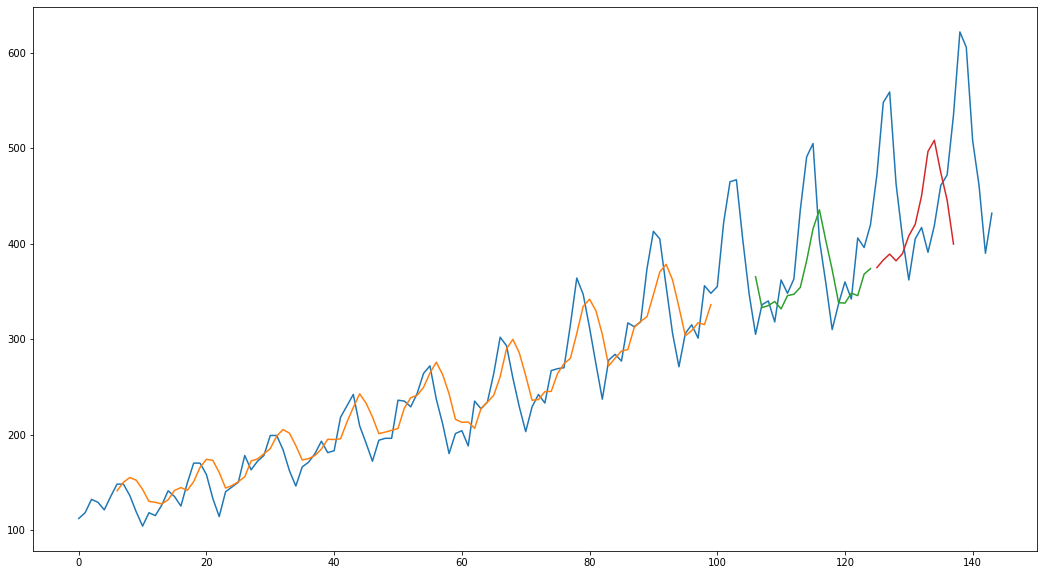

In [181]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(normalized_univariate_array)
train_predict_plot[:, :] = np.nan
# reshape in order to fill only the training examples
train_predict_plot[input_window_size:len(predictions_for_train_denormalized)+input_window_size, :] = predictions_for_train_denormalized

# shift validation predictions for plotting
validation_predict_plot = np.empty_like(normalized_univariate_array)
validation_predict_plot[:, :] = np.nan
validation_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized), :] = predictions_for_val_denormalized

# shift test predictions for plotting
test_predict_plot = np.empty_like(normalized_univariate_array)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized)+len(predictions_for_test_denormalized)] = predictions_for_test_denormalized


# plot baseline and predictions
fig = plt.figure(figsize=(18, 10))
plt.plot(scaler.inverse_transform(normalized_univariate_array))
plt.plot(train_predict_plot)
plt.plot(validation_predict_plot)
plt.plot(test_predict_plot)
plt.show()

## Shorter input window size performs much better. Let's try further decreasing it to 3 months.

In [182]:
input_window_size = 3
output_window_size = 1

train_samples, val_samples, test_samples = create_samples(train_set, validation_set, test_set, input_window_size, output_window_size)

Number of training samples: 97, validation samples: 22, test samples: 16


In [183]:
approach = "univariate"

# training & hyperparameter tuning
LOG_DIR = f"{int((time.time()))}"

tuner = RandomSearch(
        build_model,
        objective="val_mean_absolute_error", # evtl. RMSE
        max_trials= 5,
        executions_per_trial=3,
        directory='one_step_univariate/tuning_logs',
        project_name=LOG_DIR
    )
    
tuner.search(
    x=train_samples[0],
    y=train_samples[1],
    epochs=100,
    batch_size=32,
    validation_data=(val_samples[0], val_samples[1]),
    callbacks=[EarlyStopping('val_loss', patience=5)])
    
# get best model
model = tuner.get_best_models(num_models=1)[0]
model.save(f"../models/{approach}_{input_window_size}")

Train on 97 samples, validate on 22 samples
Epoch 1/100
97/97 [==============================] - ETA: 1s - loss: 0.0806 - mean_absolute_error: 0.242 - 1s 10ms/sample - loss: 0.0691 - mean_absolute_error: 0.2164 - val_loss: 0.2010 - val_mean_absolute_error: 0.4357
Epoch 2/100
97/97 [==============================] - ETA: 0s - loss: 0.0459 - mean_absolute_error: 0.169 - 0s 333us/sample - loss: 0.0325 - mean_absolute_error: 0.1385 - val_loss: 0.1166 - val_mean_absolute_error: 0.3249
Epoch 3/100
97/97 [==============================] - ETA: 0s - loss: 0.0157 - mean_absolute_error: 0.098 - 0s 314us/sample - loss: 0.0176 - mean_absolute_error: 0.1076 - val_loss: 0.0654 - val_mean_absolute_error: 0.2336
Epoch 4/100
97/97 [==============================] - ETA: 0s - loss: 0.0181 - mean_absolute_error: 0.116 - 0s 294us/sample - loss: 0.0211 - mean_absolute_error: 0.1242 - val_loss: 0.0441 - val_mean_absolute_error: 0.1831
Epoch 5/100
97/97 [==============================] - ETA: 0s - loss: 0.01

Epoch 4/100
97/97 [==============================] - ETA: 0s - loss: 0.0172 - mean_absolute_error: 0.105 - 0s 190us/sample - loss: 0.0224 - mean_absolute_error: 0.1164 - val_loss: 0.1090 - val_mean_absolute_error: 0.3131
Epoch 5/100
97/97 [==============================] - ETA: 0s - loss: 0.0156 - mean_absolute_error: 0.098 - 0s 204us/sample - loss: 0.0171 - mean_absolute_error: 0.1070 - val_loss: 0.0730 - val_mean_absolute_error: 0.2494
Epoch 6/100
97/97 [==============================] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.101 - 0s 208us/sample - loss: 0.0173 - mean_absolute_error: 0.1116 - val_loss: 0.0492 - val_mean_absolute_error: 0.1964
Epoch 7/100
97/97 [==============================] - ETA: 0s - loss: 0.0177 - mean_absolute_error: 0.111 - 0s 189us/sample - loss: 0.0185 - mean_absolute_error: 0.1160 - val_loss: 0.0461 - val_mean_absolute_error: 0.1886
Epoch 8/100
97/97 [==============================] - ETA: 0s - loss: 0.0167 - mean_absolute_error: 0.109 - 0s 174us/

Train on 97 samples, validate on 22 samples
Epoch 1/100
97/97 [==============================] - ETA: 1s - loss: 0.0755 - mean_absolute_error: 0.240 - 1s 10ms/sample - loss: 0.0874 - mean_absolute_error: 0.2502 - val_loss: 0.3355 - val_mean_absolute_error: 0.5683
Epoch 2/100
97/97 [==============================] - ETA: 0s - loss: 0.0719 - mean_absolute_error: 0.224 - 0s 257us/sample - loss: 0.0725 - mean_absolute_error: 0.2230 - val_loss: 0.2957 - val_mean_absolute_error: 0.5325
Epoch 3/100
97/97 [==============================] - ETA: 0s - loss: 0.0748 - mean_absolute_error: 0.226 - 0s 266us/sample - loss: 0.0623 - mean_absolute_error: 0.2031 - val_loss: 0.2643 - val_mean_absolute_error: 0.5024
Epoch 4/100
97/97 [==============================] - ETA: 0s - loss: 0.0656 - mean_absolute_error: 0.200 - 0s 249us/sample - loss: 0.0527 - mean_absolute_error: 0.1845 - val_loss: 0.2368 - val_mean_absolute_error: 0.4745
Epoch 5/100
97/97 [==============================] - ETA: 0s - loss: 0.03

Epoch 38/100
97/97 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.060 - 0s 192us/sample - loss: 0.0049 - mean_absolute_error: 0.0541 - val_loss: 0.0153 - val_mean_absolute_error: 0.0974
Epoch 39/100
97/97 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.050 - 0s 197us/sample - loss: 0.0043 - mean_absolute_error: 0.0501 - val_loss: 0.0174 - val_mean_absolute_error: 0.1074
Epoch 40/100
97/97 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.056 - 0s 202us/sample - loss: 0.0054 - mean_absolute_error: 0.0577 - val_loss: 0.0206 - val_mean_absolute_error: 0.1195
Epoch 41/100
97/97 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.064 - 0s 213us/sample - loss: 0.0061 - mean_absolute_error: 0.0604 - val_loss: 0.0202 - val_mean_absolute_error: 0.1183
Epoch 42/100
97/97 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.059 - 0s 1

Epoch 17/100
97/97 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.079 - 0s 178us/sample - loss: 0.0104 - mean_absolute_error: 0.0846 - val_loss: 0.0417 - val_mean_absolute_error: 0.1774
Epoch 18/100
97/97 [==============================] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.100 - 0s 180us/sample - loss: 0.0101 - mean_absolute_error: 0.0838 - val_loss: 0.0383 - val_mean_absolute_error: 0.1674


Train on 97 samples, validate on 22 samples
Epoch 1/100
97/97 [==============================] - ETA: 1s - loss: 0.0956 - mean_absolute_error: 0.269 - 1s 9ms/sample - loss: 0.0725 - mean_absolute_error: 0.2243 - val_loss: 0.2485 - val_mean_absolute_error: 0.4868
Epoch 2/100
97/97 [==============================] - ETA: 0s - loss: 0.0529 - mean_absolute_error: 0.185 - 0s 275us/sample - loss: 0.0441 - mean_absolute_error: 0.1643 - val_loss: 0.1660 - val_mean_absolute_error: 0.3935
Epoch 3/100
97/97 [==============================] - ETA: 0s - loss: 0.0268 - mean_absolute_error: 0.132 - 0s 291us/sample - loss: 0.0246 - mean_absolute_error: 0.1209 - val_loss: 0.0977 - val_mean_absolute_error: 0.2948
Epoch 4/100
97/97 [==============================] - ETA: 0s - loss: 0.0196 - mean_absolute_error: 0.114 - 0s 294us/sample - loss: 0.0167 - mean_absolute_error: 0.1082 - val_loss: 0.0445 - val_mean_absolute_error: 0.1842
Epoch 5/100
97/97 [==============================] - ETA: 0s - loss: 0.020

97/97 [==============================] - ETA: 0s - loss: 0.0196 - mean_absolute_error: 0.112 - 0s 175us/sample - loss: 0.0207 - mean_absolute_error: 0.1208 - val_loss: 0.0895 - val_mean_absolute_error: 0.2795
Epoch 14/100
97/97 [==============================] - ETA: 0s - loss: 0.0187 - mean_absolute_error: 0.115 - 0s 155us/sample - loss: 0.0205 - mean_absolute_error: 0.1198 - val_loss: 0.0917 - val_mean_absolute_error: 0.2835
Epoch 15/100
97/97 [==============================] - ETA: 0s - loss: 0.0168 - mean_absolute_error: 0.105 - 0s 151us/sample - loss: 0.0202 - mean_absolute_error: 0.1188 - val_loss: 0.0951 - val_mean_absolute_error: 0.2894
Epoch 16/100
97/97 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.130 - 0s 161us/sample - loss: 0.0200 - mean_absolute_error: 0.1181 - val_loss: 0.0978 - val_mean_absolute_error: 0.2940
Epoch 17/100
97/97 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.121 - 0s 165us/sample -

Train on 97 samples, validate on 22 samples
Epoch 1/100
97/97 [==============================] - ETA: 1s - loss: 0.0898 - mean_absolute_error: 0.255 - 1s 9ms/sample - loss: 0.0737 - mean_absolute_error: 0.2305 - val_loss: 0.3041 - val_mean_absolute_error: 0.5410
Epoch 2/100
97/97 [==============================] - ETA: 0s - loss: 0.0626 - mean_absolute_error: 0.214 - 0s 243us/sample - loss: 0.0722 - mean_absolute_error: 0.2276 - val_loss: 0.3001 - val_mean_absolute_error: 0.5373
Epoch 3/100
97/97 [==============================] - ETA: 0s - loss: 0.0722 - mean_absolute_error: 0.240 - 0s 256us/sample - loss: 0.0710 - mean_absolute_error: 0.2254 - val_loss: 0.2964 - val_mean_absolute_error: 0.5339
Epoch 4/100
97/97 [==============================] - ETA: 0s - loss: 0.0783 - mean_absolute_error: 0.243 - 0s 242us/sample - loss: 0.0698 - mean_absolute_error: 0.2232 - val_loss: 0.2928 - val_mean_absolute_error: 0.5305
Epoch 5/100
97/97 [==============================] - ETA: 0s - loss: 0.084

Epoch 38/100
97/97 [==============================] - ETA: 0s - loss: 0.0417 - mean_absolute_error: 0.153 - 0s 263us/sample - loss: 0.0364 - mean_absolute_error: 0.1467 - val_loss: 0.1822 - val_mean_absolute_error: 0.4139
Epoch 39/100
97/97 [==============================] - ETA: 0s - loss: 0.0467 - mean_absolute_error: 0.171 - 0s 261us/sample - loss: 0.0370 - mean_absolute_error: 0.1488 - val_loss: 0.1796 - val_mean_absolute_error: 0.4107
Epoch 40/100
97/97 [==============================] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.137 - 0s 239us/sample - loss: 0.0360 - mean_absolute_error: 0.1462 - val_loss: 0.1767 - val_mean_absolute_error: 0.4073
Epoch 41/100
97/97 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.139 - 0s 250us/sample - loss: 0.0334 - mean_absolute_error: 0.1384 - val_loss: 0.1736 - val_mean_absolute_error: 0.4033
Epoch 42/100
97/97 [==============================] - ETA: 0s - loss: 0.0517 - mean_absolute_error: 0.175 - 0s 2

Epoch 75/100
97/97 [==============================] - ETA: 0s - loss: 0.0170 - mean_absolute_error: 0.090 - 0s 241us/sample - loss: 0.0188 - mean_absolute_error: 0.1039 - val_loss: 0.0970 - val_mean_absolute_error: 0.2937
Epoch 76/100
97/97 [==============================] - ETA: 0s - loss: 0.0188 - mean_absolute_error: 0.110 - 0s 259us/sample - loss: 0.0162 - mean_absolute_error: 0.0985 - val_loss: 0.0952 - val_mean_absolute_error: 0.2906
Epoch 77/100
97/97 [==============================] - ETA: 0s - loss: 0.0195 - mean_absolute_error: 0.104 - 0s 258us/sample - loss: 0.0176 - mean_absolute_error: 0.1019 - val_loss: 0.0933 - val_mean_absolute_error: 0.2875
Epoch 78/100
97/97 [==============================] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.096 - 0s 234us/sample - loss: 0.0166 - mean_absolute_error: 0.0964 - val_loss: 0.0920 - val_mean_absolute_error: 0.2851
Epoch 79/100
97/97 [==============================] - ETA: 0s - loss: 0.0155 - mean_absolute_error: 0.099 - 0s 2

Epoch 12/100
97/97 [==============================] - ETA: 0s - loss: 0.0736 - mean_absolute_error: 0.231 - 0s 197us/sample - loss: 0.0673 - mean_absolute_error: 0.2184 - val_loss: 0.2844 - val_mean_absolute_error: 0.5225
Epoch 13/100
97/97 [==============================] - ETA: 0s - loss: 0.0663 - mean_absolute_error: 0.231 - 0s 176us/sample - loss: 0.0669 - mean_absolute_error: 0.2174 - val_loss: 0.2832 - val_mean_absolute_error: 0.5213
Epoch 14/100
97/97 [==============================] - ETA: 0s - loss: 0.0690 - mean_absolute_error: 0.223 - 0s 178us/sample - loss: 0.0663 - mean_absolute_error: 0.2161 - val_loss: 0.2818 - val_mean_absolute_error: 0.5200
Epoch 15/100
97/97 [==============================] - ETA: 0s - loss: 0.0688 - mean_absolute_error: 0.213 - 0s 175us/sample - loss: 0.0658 - mean_absolute_error: 0.2151 - val_loss: 0.2803 - val_mean_absolute_error: 0.5185
Epoch 16/100
97/97 [==============================] - ETA: 0s - loss: 0.0707 - mean_absolute_error: 0.223 - 0s 1

Epoch 49/100
97/97 [==============================] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.204 - 0s 185us/sample - loss: 0.0499 - mean_absolute_error: 0.1803 - val_loss: 0.2333 - val_mean_absolute_error: 0.4714
Epoch 50/100
97/97 [==============================] - ETA: 0s - loss: 0.0457 - mean_absolute_error: 0.164 - 0s 179us/sample - loss: 0.0504 - mean_absolute_error: 0.1810 - val_loss: 0.2320 - val_mean_absolute_error: 0.4699
Epoch 51/100
97/97 [==============================] - ETA: 0s - loss: 0.0588 - mean_absolute_error: 0.199 - 0s 169us/sample - loss: 0.0494 - mean_absolute_error: 0.1793 - val_loss: 0.2307 - val_mean_absolute_error: 0.4685
Epoch 52/100
97/97 [==============================] - ETA: 0s - loss: 0.0493 - mean_absolute_error: 0.188 - 0s 188us/sample - loss: 0.0489 - mean_absolute_error: 0.1782 - val_loss: 0.2294 - val_mean_absolute_error: 0.4672
Epoch 53/100
97/97 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.155 - 0s 1

Epoch 86/100
97/97 [==============================] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.138 - 0s 209us/sample - loss: 0.0369 - mean_absolute_error: 0.1499 - val_loss: 0.1890 - val_mean_absolute_error: 0.4219
Epoch 87/100
97/97 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.140 - 0s 175us/sample - loss: 0.0384 - mean_absolute_error: 0.1522 - val_loss: 0.1878 - val_mean_absolute_error: 0.4205
Epoch 88/100
97/97 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.136 - 0s 183us/sample - loss: 0.0370 - mean_absolute_error: 0.1489 - val_loss: 0.1864 - val_mean_absolute_error: 0.4189
Epoch 89/100
97/97 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.143 - 0s 192us/sample - loss: 0.0369 - mean_absolute_error: 0.1490 - val_loss: 0.1852 - val_mean_absolute_error: 0.4174
Epoch 90/100
97/97 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.147 - 0s 1

Epoch 23/100
97/97 [==============================] - ETA: 0s - loss: 0.0631 - mean_absolute_error: 0.203 - 0s 168us/sample - loss: 0.0517 - mean_absolute_error: 0.1859 - val_loss: 0.2318 - val_mean_absolute_error: 0.4699
Epoch 24/100
97/97 [==============================] - ETA: 0s - loss: 0.0467 - mean_absolute_error: 0.182 - 0s 187us/sample - loss: 0.0516 - mean_absolute_error: 0.1856 - val_loss: 0.2299 - val_mean_absolute_error: 0.4679
Epoch 25/100
97/97 [==============================] - ETA: 0s - loss: 0.0527 - mean_absolute_error: 0.196 - 0s 198us/sample - loss: 0.0514 - mean_absolute_error: 0.1850 - val_loss: 0.2280 - val_mean_absolute_error: 0.4658
Epoch 26/100
97/97 [==============================] - ETA: 0s - loss: 0.0600 - mean_absolute_error: 0.199 - 0s 219us/sample - loss: 0.0506 - mean_absolute_error: 0.1837 - val_loss: 0.2261 - val_mean_absolute_error: 0.4639
Epoch 27/100
97/97 [==============================] - ETA: 0s - loss: 0.0529 - mean_absolute_error: 0.191 - 0s 1

Epoch 60/100
97/97 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.140 - 0s 215us/sample - loss: 0.0323 - mean_absolute_error: 0.1405 - val_loss: 0.1683 - val_mean_absolute_error: 0.3969
Epoch 61/100
97/97 [==============================] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.163 - 0s 218us/sample - loss: 0.0305 - mean_absolute_error: 0.1355 - val_loss: 0.1667 - val_mean_absolute_error: 0.3948
Epoch 62/100
97/97 [==============================] - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.164 - 0s 181us/sample - loss: 0.0334 - mean_absolute_error: 0.1404 - val_loss: 0.1651 - val_mean_absolute_error: 0.3928
Epoch 63/100
97/97 [==============================] - ETA: 0s - loss: 0.0183 - mean_absolute_error: 0.097 - 0s 187us/sample - loss: 0.0312 - mean_absolute_error: 0.1344 - val_loss: 0.1635 - val_mean_absolute_error: 0.3908
Epoch 64/100
97/97 [==============================] - ETA: 0s - loss: 0.0420 - mean_absolute_error: 0.166 - 0s 1

Epoch 97/100
97/97 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.138 - 0s 195us/sample - loss: 0.0217 - mean_absolute_error: 0.1055 - val_loss: 0.1051 - val_mean_absolute_error: 0.3074
Epoch 98/100
97/97 [==============================] - ETA: 0s - loss: 0.0191 - mean_absolute_error: 0.096 - 0s 227us/sample - loss: 0.0190 - mean_absolute_error: 0.1015 - val_loss: 0.1039 - val_mean_absolute_error: 0.3054
Epoch 99/100
97/97 [==============================] - ETA: 0s - loss: 0.0154 - mean_absolute_error: 0.099 - 0s 194us/sample - loss: 0.0204 - mean_absolute_error: 0.1047 - val_loss: 0.1026 - val_mean_absolute_error: 0.3033
Epoch 100/100
97/97 [==============================] - ETA: 0s - loss: 0.0191 - mean_absolute_error: 0.093 - 0s 191us/sample - loss: 0.0237 - mean_absolute_error: 0.1068 - val_loss: 0.1013 - val_mean_absolute_error: 0.3012


Train on 97 samples, validate on 22 samples
Epoch 1/100
97/97 [==============================] - ETA: 1s - loss: 0.0812 - mean_absolute_error: 0.242 - 1s 9ms/sample - loss: 0.0580 - mean_absolute_error: 0.1964 - val_loss: 0.1565 - val_mean_absolute_error: 0.3817
Epoch 2/100
97/97 [==============================] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.159 - 0s 233us/sample - loss: 0.0250 - mean_absolute_error: 0.1235 - val_loss: 0.0695 - val_mean_absolute_error: 0.2429
Epoch 3/100
97/97 [==============================] - ETA: 0s - loss: 0.0183 - mean_absolute_error: 0.111 - 0s 286us/sample - loss: 0.0199 - mean_absolute_error: 0.1185 - val_loss: 0.0614 - val_mean_absolute_error: 0.2259
Epoch 4/100
97/97 [==============================] - ETA: 0s - loss: 0.0185 - mean_absolute_error: 0.108 - 0s 183us/sample - loss: 0.0186 - mean_absolute_error: 0.1135 - val_loss: 0.0734 - val_mean_absolute_error: 0.2511
Epoch 5/100
97/97 [==============================] - ETA: 0s - loss: 0.019

97/97 [==============================] - ETA: 0s - loss: 0.0186 - mean_absolute_error: 0.120 - 0s 190us/sample - loss: 0.0176 - mean_absolute_error: 0.1133 - val_loss: 0.0577 - val_mean_absolute_error: 0.2187
Epoch 4/100
97/97 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.081 - 0s 188us/sample - loss: 0.0145 - mean_absolute_error: 0.0933 - val_loss: 0.0693 - val_mean_absolute_error: 0.2441
Epoch 5/100
97/97 [==============================] - ETA: 0s - loss: 0.0168 - mean_absolute_error: 0.106 - 0s 199us/sample - loss: 0.0135 - mean_absolute_error: 0.0921 - val_loss: 0.0284 - val_mean_absolute_error: 0.1402
Epoch 6/100
97/97 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.086 - 0s 197us/sample - loss: 0.0125 - mean_absolute_error: 0.0954 - val_loss: 0.0290 - val_mean_absolute_error: 0.1421
Epoch 7/100
97/97 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.069 - 0s 182us/sample - los

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ../models/univariate_3/assets


In [184]:
# make predictions
predictions_for_train = model.predict(train_samples[0])
predictions_for_validation = model.predict(val_samples[0])
predictions_for_test = model.predict(test_samples[0])
predictions_for_test

# invert predictions
predictions_for_train_denormalized = scaler.inverse_transform(predictions_for_train)
true_values_train = scaler.inverse_transform(train_samples[1])

predictions_for_val_denormalized = scaler.inverse_transform(predictions_for_validation)
true_values_val = scaler.inverse_transform(val_samples[1])

predictions_for_test_denormalized = scaler.inverse_transform(predictions_for_test)
true_values_test = scaler.inverse_transform(test_samples[1])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(true_values_train, predictions_for_train_denormalized))
print('Train Score: %.2f RMSE' % (train_score))

validation_score = math.sqrt(mean_squared_error(true_values_val, predictions_for_val_denormalized))
print('Validation Score: %.2f RMSE' % (validation_score))

test_score = math.sqrt(mean_squared_error(true_values_test, predictions_for_test_denormalized))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 35.80 RMSE
Validation Score: 56.18 RMSE
Test Score: 72.19 RMSE


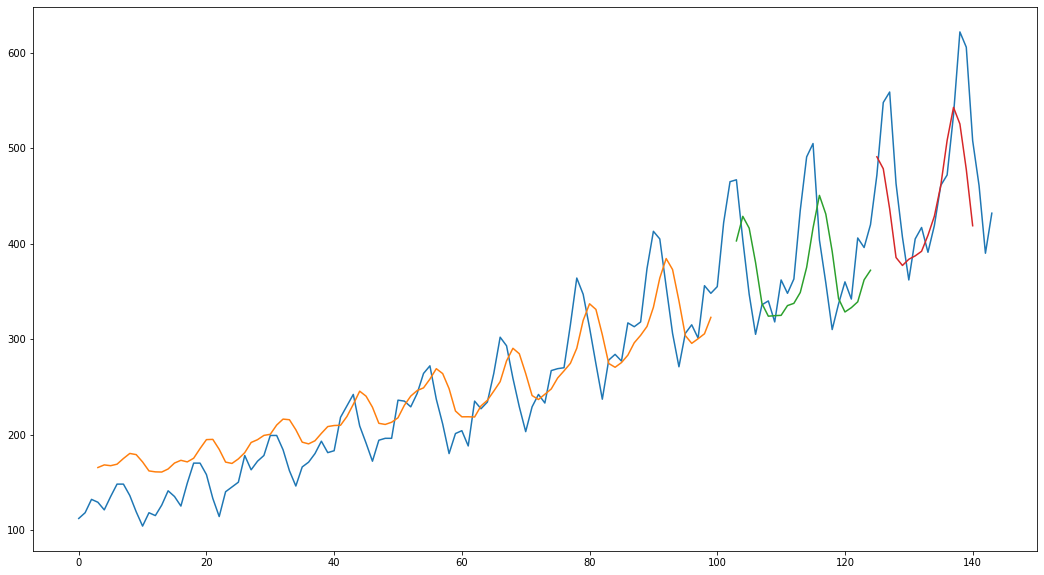

In [185]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(normalized_univariate_array)
train_predict_plot[:, :] = np.nan
# reshape in order to fill only the training examples
train_predict_plot[input_window_size:len(predictions_for_train_denormalized)+input_window_size, :] = predictions_for_train_denormalized

# shift validation predictions for plotting
validation_predict_plot = np.empty_like(normalized_univariate_array)
validation_predict_plot[:, :] = np.nan
validation_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized), :] = predictions_for_val_denormalized

# shift test predictions for plotting
test_predict_plot = np.empty_like(normalized_univariate_array)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized)+len(predictions_for_test_denormalized)] = predictions_for_test_denormalized


# plot baseline and predictions
fig = plt.figure(figsize=(18, 10))
plt.plot(scaler.inverse_transform(normalized_univariate_array))
plt.plot(train_predict_plot)
plt.plot(validation_predict_plot)
plt.plot(test_predict_plot)
plt.show()

## Last experiment regarding the input window size. Let's set it to 5.

In [188]:
input_window_size = 5
output_window_size = 1

train_samples, val_samples, test_samples = create_samples(train_set, validation_set, test_set, input_window_size, output_window_size)

Number of training samples: 95, validation samples: 20, test samples: 14


In [189]:
approach = "univariate"

# training & hyperparameter tuning
LOG_DIR = f"{int((time.time()))}"

tuner = RandomSearch(
        build_model,
        objective="val_mean_absolute_error", # evtl. RMSE
        max_trials= 5,
        executions_per_trial=3,
        directory='one_step_univariate/tuning_logs',
        project_name=LOG_DIR
    )
    
tuner.search(
    x=train_samples[0],
    y=train_samples[1],
    epochs=100,
    batch_size=32,
    validation_data=(val_samples[0], val_samples[1]),
    callbacks=[EarlyStopping('val_loss', patience=5)])
    
# get best model
model = tuner.get_best_models(num_models=1)[0]
model.save(f"../models/{approach}_{input_window_size}")

Train on 95 samples, validate on 20 samples
Epoch 1/100
95/95 [==============================] - ETA: 1s - loss: 0.0875 - mean_absolute_error: 0.253 - 1s 11ms/sample - loss: 0.0789 - mean_absolute_error: 0.2397 - val_loss: 0.2998 - val_mean_absolute_error: 0.5374
Epoch 2/100
95/95 [==============================] - ETA: 0s - loss: 0.0636 - mean_absolute_error: 0.215 - 0s 331us/sample - loss: 0.0727 - mean_absolute_error: 0.2281 - val_loss: 0.2826 - val_mean_absolute_error: 0.5212
Epoch 3/100
95/95 [==============================] - ETA: 0s - loss: 0.0843 - mean_absolute_error: 0.243 - 0s 307us/sample - loss: 0.0673 - mean_absolute_error: 0.2168 - val_loss: 0.2663 - val_mean_absolute_error: 0.5052
Epoch 4/100
95/95 [==============================] - ETA: 0s - loss: 0.0700 - mean_absolute_error: 0.226 - 0s 298us/sample - loss: 0.0620 - mean_absolute_error: 0.2062 - val_loss: 0.2509 - val_mean_absolute_error: 0.4897
Epoch 5/100
95/95 [==============================] - ETA: 0s - loss: 0.07

Epoch 34/100
95/95 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.057 - 0s 268us/sample - loss: 0.0079 - mean_absolute_error: 0.0726 - val_loss: 0.0277 - val_mean_absolute_error: 0.1309
Epoch 35/100
95/95 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.064 - 0s 251us/sample - loss: 0.0076 - mean_absolute_error: 0.0710 - val_loss: 0.0262 - val_mean_absolute_error: 0.1256
Epoch 36/100
95/95 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.070 - 0s 282us/sample - loss: 0.0073 - mean_absolute_error: 0.0695 - val_loss: 0.0248 - val_mean_absolute_error: 0.1202
Epoch 37/100
95/95 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.075 - 0s 258us/sample - loss: 0.0070 - mean_absolute_error: 0.0682 - val_loss: 0.0232 - val_mean_absolute_error: 0.1146
Epoch 38/100
95/95 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.064 - 0s 2

Epoch 5/100
95/95 [==============================] - ETA: 0s - loss: 0.0402 - mean_absolute_error: 0.161 - 0s 182us/sample - loss: 0.0473 - mean_absolute_error: 0.1766 - val_loss: 0.1941 - val_mean_absolute_error: 0.4277
Epoch 6/100
95/95 [==============================] - ETA: 0s - loss: 0.0449 - mean_absolute_error: 0.171 - 0s 178us/sample - loss: 0.0421 - mean_absolute_error: 0.1636 - val_loss: 0.1773 - val_mean_absolute_error: 0.4076
Epoch 7/100
95/95 [==============================] - ETA: 0s - loss: 0.0310 - mean_absolute_error: 0.152 - 0s 182us/sample - loss: 0.0371 - mean_absolute_error: 0.1517 - val_loss: 0.1607 - val_mean_absolute_error: 0.3866
Epoch 8/100
95/95 [==============================] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.151 - 0s 178us/sample - loss: 0.0324 - mean_absolute_error: 0.1396 - val_loss: 0.1441 - val_mean_absolute_error: 0.3642
Epoch 9/100
95/95 [==============================] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.128 - 0s 176us/

Epoch 42/100
95/95 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.053 - 0s 200us/sample - loss: 0.0046 - mean_absolute_error: 0.0525 - val_loss: 0.0165 - val_mean_absolute_error: 0.1040
Epoch 43/100
95/95 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.052 - 0s 176us/sample - loss: 0.0045 - mean_absolute_error: 0.0524 - val_loss: 0.0165 - val_mean_absolute_error: 0.1040
Epoch 44/100
95/95 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.048 - 0s 192us/sample - loss: 0.0045 - mean_absolute_error: 0.0523 - val_loss: 0.0164 - val_mean_absolute_error: 0.1035
Epoch 45/100
95/95 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.053 - 0s 199us/sample - loss: 0.0045 - mean_absolute_error: 0.0520 - val_loss: 0.0164 - val_mean_absolute_error: 0.1031
Epoch 46/100
95/95 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.054 - 0s 2

Epoch 79/100
95/95 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.056 - 0s 240us/sample - loss: 0.0039 - mean_absolute_error: 0.0481 - val_loss: 0.0140 - val_mean_absolute_error: 0.0922
Epoch 80/100
95/95 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.054 - 0s 235us/sample - loss: 0.0039 - mean_absolute_error: 0.0479 - val_loss: 0.0139 - val_mean_absolute_error: 0.0918
Epoch 81/100
95/95 [==============================] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.042 - 0s 299us/sample - loss: 0.0038 - mean_absolute_error: 0.0477 - val_loss: 0.0138 - val_mean_absolute_error: 0.0915
Epoch 82/100
95/95 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.054 - 0s 303us/sample - loss: 0.0038 - mean_absolute_error: 0.0478 - val_loss: 0.0137 - val_mean_absolute_error: 0.0913
Epoch 83/100
95/95 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.046 - 0s 3

Epoch 16/100
95/95 [==============================] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.095 - 0s 167us/sample - loss: 0.0114 - mean_absolute_error: 0.0890 - val_loss: 0.0385 - val_mean_absolute_error: 0.1634
Epoch 17/100
95/95 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.083 - 0s 204us/sample - loss: 0.0113 - mean_absolute_error: 0.0889 - val_loss: 0.0352 - val_mean_absolute_error: 0.1542
Epoch 18/100
95/95 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.079 - 0s 197us/sample - loss: 0.0110 - mean_absolute_error: 0.0878 - val_loss: 0.0341 - val_mean_absolute_error: 0.1513
Epoch 19/100
95/95 [==============================] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.090 - 0s 173us/sample - loss: 0.0107 - mean_absolute_error: 0.0865 - val_loss: 0.0339 - val_mean_absolute_error: 0.1508
Epoch 20/100
95/95 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.086 - 0s 1

Train on 95 samples, validate on 20 samples
Epoch 1/100
95/95 [==============================] - ETA: 1s - loss: 0.0533 - mean_absolute_error: 0.188 - 1s 9ms/sample - loss: 0.0284 - mean_absolute_error: 0.1275 - val_loss: 0.0184 - val_mean_absolute_error: 0.1008
Epoch 2/100
95/95 [==============================] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.095 - 0s 265us/sample - loss: 0.0187 - mean_absolute_error: 0.1179 - val_loss: 0.0149 - val_mean_absolute_error: 0.0930
Epoch 3/100
95/95 [==============================] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.098 - 0s 197us/sample - loss: 0.0110 - mean_absolute_error: 0.0877 - val_loss: 0.0463 - val_mean_absolute_error: 0.1866
Epoch 4/100
95/95 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.052 - 0s 178us/sample - loss: 0.0122 - mean_absolute_error: 0.0844 - val_loss: 0.0610 - val_mean_absolute_error: 0.2227
Epoch 5/100
95/95 [==============================] - ETA: 0s - loss: 0.015

95/95 [==============================] - ETA: 0s - loss: 0.0180 - mean_absolute_error: 0.110 - 0s 190us/sample - loss: 0.0197 - mean_absolute_error: 0.1166 - val_loss: 0.0892 - val_mean_absolute_error: 0.2799
Epoch 19/100
95/95 [==============================] - ETA: 0s - loss: 0.0207 - mean_absolute_error: 0.118 - 0s 203us/sample - loss: 0.0196 - mean_absolute_error: 0.1162 - val_loss: 0.0915 - val_mean_absolute_error: 0.2841


Train on 95 samples, validate on 20 samples
Epoch 1/100
95/95 [==============================] - ETA: 1s - loss: 0.0703 - mean_absolute_error: 0.229 - 1s 9ms/sample - loss: 0.0575 - mean_absolute_error: 0.1985 - val_loss: 0.1640 - val_mean_absolute_error: 0.3914
Epoch 2/100
95/95 [==============================] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.139 - 0s 229us/sample - loss: 0.0266 - mean_absolute_error: 0.1237 - val_loss: 0.0833 - val_mean_absolute_error: 0.2688
Epoch 3/100
95/95 [==============================] - ETA: 0s - loss: 0.0188 - mean_absolute_error: 0.108 - 0s 247us/sample - loss: 0.0138 - mean_absolute_error: 0.0936 - val_loss: 0.0325 - val_mean_absolute_error: 0.1473
Epoch 4/100
95/95 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.079 - 0s 240us/sample - loss: 0.0135 - mean_absolute_error: 0.0982 - val_loss: 0.0186 - val_mean_absolute_error: 0.1007
Epoch 5/100
95/95 [==============================] - ETA: 0s - loss: 0.015

Train on 95 samples, validate on 20 samples
Epoch 1/100
95/95 [==============================] - ETA: 1s - loss: 0.0821 - mean_absolute_error: 0.241 - 1s 10ms/sample - loss: 0.0863 - mean_absolute_error: 0.2503 - val_loss: 0.3159 - val_mean_absolute_error: 0.5521
Epoch 2/100
95/95 [==============================] - ETA: 0s - loss: 0.0469 - mean_absolute_error: 0.183 - 0s 250us/sample - loss: 0.0709 - mean_absolute_error: 0.2236 - val_loss: 0.2736 - val_mean_absolute_error: 0.5124
Epoch 3/100
95/95 [==============================] - ETA: 0s - loss: 0.0458 - mean_absolute_error: 0.169 - 0s 280us/sample - loss: 0.0596 - mean_absolute_error: 0.2010 - val_loss: 0.2367 - val_mean_absolute_error: 0.4750
Epoch 4/100
95/95 [==============================] - ETA: 0s - loss: 0.0449 - mean_absolute_error: 0.173 - 0s 253us/sample - loss: 0.0498 - mean_absolute_error: 0.1800 - val_loss: 0.2016 - val_mean_absolute_error: 0.4365
Epoch 5/100
95/95 [==============================] - ETA: 0s - loss: 0.05

Epoch 4/100
95/95 [==============================] - ETA: 0s - loss: 0.0485 - mean_absolute_error: 0.170 - 0s 182us/sample - loss: 0.0428 - mean_absolute_error: 0.1652 - val_loss: 0.1726 - val_mean_absolute_error: 0.4021
Epoch 5/100
95/95 [==============================] - ETA: 0s - loss: 0.0444 - mean_absolute_error: 0.172 - 0s 176us/sample - loss: 0.0362 - mean_absolute_error: 0.1489 - val_loss: 0.1483 - val_mean_absolute_error: 0.3707
Epoch 6/100
95/95 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.146 - 0s 189us/sample - loss: 0.0291 - mean_absolute_error: 0.1307 - val_loss: 0.1227 - val_mean_absolute_error: 0.3341
Epoch 7/100
95/95 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.147 - 0s 177us/sample - loss: 0.0221 - mean_absolute_error: 0.1125 - val_loss: 0.0976 - val_mean_absolute_error: 0.2937
Epoch 8/100
95/95 [==============================] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.123 - 0s 194us/

Train on 95 samples, validate on 20 samples
Epoch 1/100
95/95 [==============================] - ETA: 1s - loss: 0.0686 - mean_absolute_error: 0.215 - 1s 10ms/sample - loss: 0.0726 - mean_absolute_error: 0.2304 - val_loss: 0.2826 - val_mean_absolute_error: 0.5213
Epoch 2/100
95/95 [==============================] - ETA: 0s - loss: 0.0700 - mean_absolute_error: 0.223 - 0s 260us/sample - loss: 0.0724 - mean_absolute_error: 0.2301 - val_loss: 0.2823 - val_mean_absolute_error: 0.5210
Epoch 3/100
95/95 [==============================] - ETA: 0s - loss: 0.0770 - mean_absolute_error: 0.241 - 0s 284us/sample - loss: 0.0723 - mean_absolute_error: 0.2298 - val_loss: 0.2820 - val_mean_absolute_error: 0.5207
Epoch 4/100
95/95 [==============================] - ETA: 0s - loss: 0.0924 - mean_absolute_error: 0.265 - 0s 247us/sample - loss: 0.0722 - mean_absolute_error: 0.2295 - val_loss: 0.2817 - val_mean_absolute_error: 0.5204
Epoch 5/100
95/95 [==============================] - ETA: 0s - loss: 0.08

Epoch 38/100
95/95 [==============================] - ETA: 0s - loss: 0.0612 - mean_absolute_error: 0.206 - 0s 294us/sample - loss: 0.0676 - mean_absolute_error: 0.2197 - val_loss: 0.2713 - val_mean_absolute_error: 0.5104
Epoch 39/100
95/95 [==============================] - ETA: 0s - loss: 0.0560 - mean_absolute_error: 0.194 - 0s 391us/sample - loss: 0.0675 - mean_absolute_error: 0.2194 - val_loss: 0.2710 - val_mean_absolute_error: 0.5101
Epoch 40/100
95/95 [==============================] - ETA: 0s - loss: 0.0650 - mean_absolute_error: 0.220 - 0s 299us/sample - loss: 0.0674 - mean_absolute_error: 0.2191 - val_loss: 0.2707 - val_mean_absolute_error: 0.5098
Epoch 41/100
95/95 [==============================] - ETA: 0s - loss: 0.0829 - mean_absolute_error: 0.249 - 0s 320us/sample - loss: 0.0673 - mean_absolute_error: 0.2188 - val_loss: 0.2704 - val_mean_absolute_error: 0.5095
Epoch 42/100
95/95 [==============================] - ETA: 0s - loss: 0.0734 - mean_absolute_error: 0.219 - 0s 3

Epoch 75/100
95/95 [==============================] - ETA: 0s - loss: 0.0502 - mean_absolute_error: 0.185 - 0s 309us/sample - loss: 0.0631 - mean_absolute_error: 0.2093 - val_loss: 0.2605 - val_mean_absolute_error: 0.4997
Epoch 76/100
95/95 [==============================] - ETA: 0s - loss: 0.0668 - mean_absolute_error: 0.216 - 0s 296us/sample - loss: 0.0629 - mean_absolute_error: 0.2090 - val_loss: 0.2602 - val_mean_absolute_error: 0.4994
Epoch 77/100
95/95 [==============================] - ETA: 0s - loss: 0.0669 - mean_absolute_error: 0.217 - 0s 295us/sample - loss: 0.0628 - mean_absolute_error: 0.2087 - val_loss: 0.2599 - val_mean_absolute_error: 0.4991
Epoch 78/100
95/95 [==============================] - ETA: 0s - loss: 0.0644 - mean_absolute_error: 0.221 - 0s 346us/sample - loss: 0.0627 - mean_absolute_error: 0.2085 - val_loss: 0.2596 - val_mean_absolute_error: 0.4988
Epoch 79/100
95/95 [==============================] - ETA: 0s - loss: 0.0659 - mean_absolute_error: 0.206 - 0s 3

Epoch 12/100
95/95 [==============================] - ETA: 0s - loss: 0.0663 - mean_absolute_error: 0.226 - 0s 202us/sample - loss: 0.0678 - mean_absolute_error: 0.2202 - val_loss: 0.2736 - val_mean_absolute_error: 0.5126
Epoch 13/100
95/95 [==============================] - ETA: 0s - loss: 0.0701 - mean_absolute_error: 0.230 - 0s 197us/sample - loss: 0.0673 - mean_absolute_error: 0.2192 - val_loss: 0.2720 - val_mean_absolute_error: 0.5110
Epoch 14/100
95/95 [==============================] - ETA: 0s - loss: 0.0751 - mean_absolute_error: 0.234 - 0s 189us/sample - loss: 0.0668 - mean_absolute_error: 0.2182 - val_loss: 0.2705 - val_mean_absolute_error: 0.5096
Epoch 15/100
95/95 [==============================] - ETA: 0s - loss: 0.0757 - mean_absolute_error: 0.234 - 0s 171us/sample - loss: 0.0662 - mean_absolute_error: 0.2172 - val_loss: 0.2691 - val_mean_absolute_error: 0.5081
Epoch 16/100
95/95 [==============================] - ETA: 0s - loss: 0.0532 - mean_absolute_error: 0.197 - 0s 1

Epoch 49/100
95/95 [==============================] - ETA: 0s - loss: 0.0463 - mean_absolute_error: 0.180 - 0s 270us/sample - loss: 0.0524 - mean_absolute_error: 0.1868 - val_loss: 0.2303 - val_mean_absolute_error: 0.4684
Epoch 50/100
95/95 [==============================] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.200 - 0s 247us/sample - loss: 0.0521 - mean_absolute_error: 0.1860 - val_loss: 0.2292 - val_mean_absolute_error: 0.4673
Epoch 51/100
95/95 [==============================] - ETA: 0s - loss: 0.0477 - mean_absolute_error: 0.174 - 0s 289us/sample - loss: 0.0517 - mean_absolute_error: 0.1851 - val_loss: 0.2282 - val_mean_absolute_error: 0.4662
Epoch 52/100
95/95 [==============================] - ETA: 0s - loss: 0.0651 - mean_absolute_error: 0.216 - 0s 273us/sample - loss: 0.0513 - mean_absolute_error: 0.1842 - val_loss: 0.2272 - val_mean_absolute_error: 0.4652
Epoch 53/100
95/95 [==============================] - ETA: 0s - loss: 0.0273 - mean_absolute_error: 0.135 - 0s 2

Epoch 86/100
95/95 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.147 - 0s 341us/sample - loss: 0.0399 - mean_absolute_error: 0.1569 - val_loss: 0.1938 - val_mean_absolute_error: 0.4277
Epoch 87/100
95/95 [==============================] - ETA: 0s - loss: 0.0492 - mean_absolute_error: 0.164 - 0s 356us/sample - loss: 0.0396 - mean_absolute_error: 0.1561 - val_loss: 0.1928 - val_mean_absolute_error: 0.4266
Epoch 88/100
95/95 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.140 - 0s 377us/sample - loss: 0.0393 - mean_absolute_error: 0.1554 - val_loss: 0.1919 - val_mean_absolute_error: 0.4255
Epoch 89/100
95/95 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.138 - 0s 338us/sample - loss: 0.0390 - mean_absolute_error: 0.1546 - val_loss: 0.1909 - val_mean_absolute_error: 0.4244
Epoch 90/100
95/95 [==============================] - ETA: 0s - loss: 0.0412 - mean_absolute_error: 0.160 - 0s 3

Epoch 23/100
95/95 [==============================] - ETA: 0s - loss: 0.0694 - mean_absolute_error: 0.224 - 0s 201us/sample - loss: 0.0646 - mean_absolute_error: 0.2131 - val_loss: 0.2657 - val_mean_absolute_error: 0.5048
Epoch 24/100
95/95 [==============================] - ETA: 0s - loss: 0.0732 - mean_absolute_error: 0.234 - 0s 200us/sample - loss: 0.0641 - mean_absolute_error: 0.2121 - val_loss: 0.2644 - val_mean_absolute_error: 0.5035
Epoch 25/100
95/95 [==============================] - ETA: 0s - loss: 0.0573 - mean_absolute_error: 0.208 - 0s 206us/sample - loss: 0.0637 - mean_absolute_error: 0.2111 - val_loss: 0.2632 - val_mean_absolute_error: 0.5023
Epoch 26/100
95/95 [==============================] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.205 - 0s 201us/sample - loss: 0.0632 - mean_absolute_error: 0.2101 - val_loss: 0.2620 - val_mean_absolute_error: 0.5011
Epoch 27/100
95/95 [==============================] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.205 - 0s 2

Epoch 60/100
95/95 [==============================] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.152 - 0s 198us/sample - loss: 0.0450 - mean_absolute_error: 0.1684 - val_loss: 0.2110 - val_mean_absolute_error: 0.4474
Epoch 61/100
95/95 [==============================] - ETA: 0s - loss: 0.0426 - mean_absolute_error: 0.165 - 0s 218us/sample - loss: 0.0445 - mean_absolute_error: 0.1673 - val_loss: 0.2095 - val_mean_absolute_error: 0.4457
Epoch 62/100
95/95 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.135 - 0s 192us/sample - loss: 0.0440 - mean_absolute_error: 0.1662 - val_loss: 0.2079 - val_mean_absolute_error: 0.4440
Epoch 63/100
95/95 [==============================] - ETA: 0s - loss: 0.0504 - mean_absolute_error: 0.173 - 0s 236us/sample - loss: 0.0436 - mean_absolute_error: 0.1650 - val_loss: 0.2064 - val_mean_absolute_error: 0.4422
Epoch 64/100
95/95 [==============================] - ETA: 0s - loss: 0.0483 - mean_absolute_error: 0.174 - 0s 2

Epoch 97/100
95/95 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.128 - 0s 292us/sample - loss: 0.0303 - mean_absolute_error: 0.1335 - val_loss: 0.1612 - val_mean_absolute_error: 0.3879
Epoch 98/100
95/95 [==============================] - ETA: 0s - loss: 0.0297 - mean_absolute_error: 0.129 - 0s 288us/sample - loss: 0.0299 - mean_absolute_error: 0.1327 - val_loss: 0.1600 - val_mean_absolute_error: 0.3863
Epoch 99/100
95/95 [==============================] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.147 - 0s 354us/sample - loss: 0.0296 - mean_absolute_error: 0.1320 - val_loss: 0.1589 - val_mean_absolute_error: 0.3848
Epoch 100/100
95/95 [==============================] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.137 - 0s 285us/sample - loss: 0.0293 - mean_absolute_error: 0.1312 - val_loss: 0.1577 - val_mean_absolute_error: 0.3832


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ../models/univariate_5/assets


In [190]:
# make predictions
predictions_for_train = model.predict(train_samples[0])
predictions_for_validation = model.predict(val_samples[0])
predictions_for_test = model.predict(test_samples[0])
predictions_for_test

# invert predictions
predictions_for_train_denormalized = scaler.inverse_transform(predictions_for_train)
true_values_train = scaler.inverse_transform(train_samples[1])

predictions_for_val_denormalized = scaler.inverse_transform(predictions_for_validation)
true_values_val = scaler.inverse_transform(val_samples[1])

predictions_for_test_denormalized = scaler.inverse_transform(predictions_for_test)
true_values_test = scaler.inverse_transform(test_samples[1])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(true_values_train, predictions_for_train_denormalized))
print('Train Score: %.2f RMSE' % (train_score))

validation_score = math.sqrt(mean_squared_error(true_values_val, predictions_for_val_denormalized))
print('Validation Score: %.2f RMSE' % (validation_score))

test_score = math.sqrt(mean_squared_error(true_values_test, predictions_for_test_denormalized))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 68.40 RMSE
Validation Score: 65.85 RMSE
Test Score: 104.17 RMSE


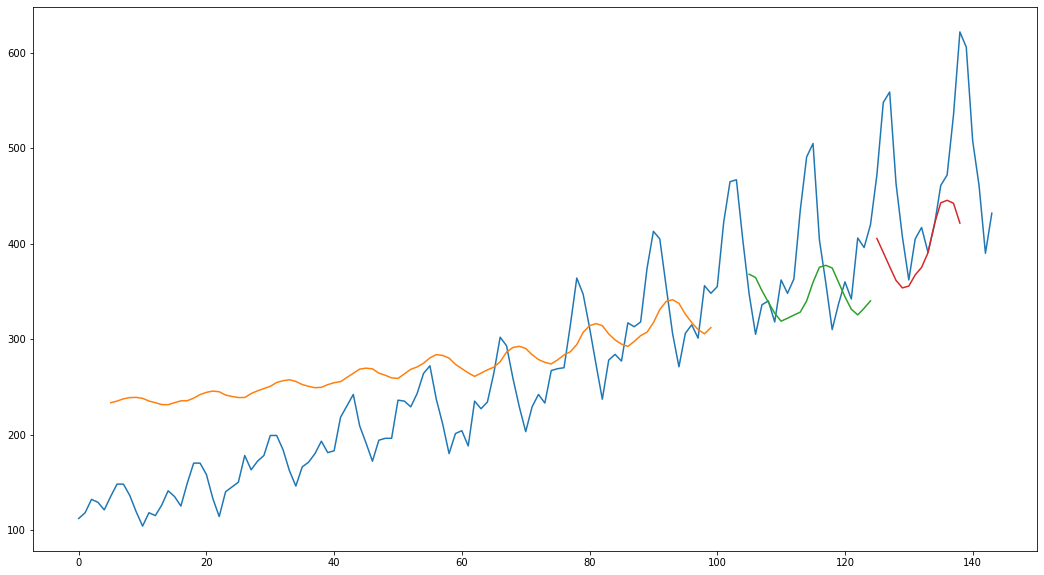

In [191]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(normalized_univariate_array)
train_predict_plot[:, :] = np.nan
# reshape in order to fill only the training examples
train_predict_plot[input_window_size:len(predictions_for_train_denormalized)+input_window_size, :] = predictions_for_train_denormalized

# shift validation predictions for plotting
validation_predict_plot = np.empty_like(normalized_univariate_array)
validation_predict_plot[:, :] = np.nan
validation_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized), :] = predictions_for_val_denormalized

# shift test predictions for plotting
test_predict_plot = np.empty_like(normalized_univariate_array)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized)+len(predictions_for_test_denormalized)] = predictions_for_test_denormalized


# plot baseline and predictions
fig = plt.figure(figsize=(18, 10))
plt.plot(scaler.inverse_transform(normalized_univariate_array))
plt.plot(train_predict_plot)
plt.plot(validation_predict_plot)
plt.plot(test_predict_plot)
plt.show()

## Let's keep the input window size equal to 6 and try changing the network architecture a little bit. Let's get rid of the dropout layer.

In [192]:
input_window_size = 6
output_window_size = 1

train_samples, val_samples, test_samples = create_samples(train_set, validation_set, test_set, input_window_size, output_window_size)

Number of training samples: 94, validation samples: 19, test samples: 13


In [193]:
def build_modified_model(hp):
    model = Sequential()
    # input LSTM layer
    model.add(LSTM(hp.Int("input_units", min_value=5, max_value=50, step=3),
                   activation='relu', input_shape=(input_window_size, 1), name="lstm"))
    
    # dense hidden layers with dropouts
    for i in range(hp.Int("n_layers", 0,2)):
        model.add(Dense(hp.Int(f"dense_{i}_units", min_value=5, max_value=50, step=3),
                        activation='relu', name=f"hidden_{i}"))    
    # dense output layer
    model.add(Dense(1, name="output"))
    model.compile(loss='mean_squared_error' , optimizer=Adam(learning_rate=
            hp.Choice("learning_rate",values=[1e-2, 1e-3, 1e-4])), metrics=[metrics.mae])
    return model

In [194]:
approach = "univariate"

# training & hyperparameter tuning
LOG_DIR = f"{int((time.time()))}"

tuner = RandomSearch(
        build_modified_model,
        objective="val_mean_absolute_error", # evtl. RMSE
        max_trials= 5,
        executions_per_trial=3,
        directory='one_step_univariate/tuning_logs',
        project_name=LOG_DIR
    )
    
tuner.search(
    x=train_samples[0],
    y=train_samples[1],
    epochs=100,
    batch_size=32,
    validation_data=(val_samples[0], val_samples[1]),
    callbacks=[EarlyStopping('val_loss', patience=5)])
    
# get best model
model = tuner.get_best_models(num_models=1)[0]
model.save(f"../models/modified_architecture_{approach}_{input_window_size}")

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0823 - mean_absolute_error: 0.257 - 1s 11ms/sample - loss: 0.0881 - mean_absolute_error: 0.2551 - val_loss: 0.3442 - val_mean_absolute_error: 0.5768
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0692 - mean_absolute_error: 0.216 - 0s 300us/sample - loss: 0.0867 - mean_absolute_error: 0.2527 - val_loss: 0.3409 - val_mean_absolute_error: 0.5739
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0852 - mean_absolute_error: 0.241 - 0s 349us/sample - loss: 0.0855 - mean_absolute_error: 0.2503 - val_loss: 0.3376 - val_mean_absolute_error: 0.5710
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0977 - mean_absolute_error: 0.264 - 0s 352us/sample - loss: 0.0843 - mean_absolute_error: 0.2480 - val_loss: 0.3343 - val_mean_absolute_error: 0.5682
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.10

Epoch 34/100
94/94 [==============================] - ETA: 0s - loss: 0.0586 - mean_absolute_error: 0.211 - 0s 436us/sample - loss: 0.0646 - mean_absolute_error: 0.2132 - val_loss: 0.2727 - val_mean_absolute_error: 0.5112
Epoch 35/100
94/94 [==============================] - ETA: 0s - loss: 0.0474 - mean_absolute_error: 0.177 - 0s 305us/sample - loss: 0.0643 - mean_absolute_error: 0.2126 - val_loss: 0.2715 - val_mean_absolute_error: 0.5100
Epoch 36/100
94/94 [==============================] - ETA: 0s - loss: 0.0499 - mean_absolute_error: 0.186 - 0s 321us/sample - loss: 0.0640 - mean_absolute_error: 0.2120 - val_loss: 0.2704 - val_mean_absolute_error: 0.5089
Epoch 37/100
94/94 [==============================] - ETA: 0s - loss: 0.0693 - mean_absolute_error: 0.216 - 0s 326us/sample - loss: 0.0637 - mean_absolute_error: 0.2113 - val_loss: 0.2693 - val_mean_absolute_error: 0.5078
Epoch 38/100
94/94 [==============================] - ETA: 0s - loss: 0.0597 - mean_absolute_error: 0.205 - 0s 3

Epoch 71/100
94/94 [==============================] - ETA: 0s - loss: 0.0739 - mean_absolute_error: 0.228 - 0s 325us/sample - loss: 0.0551 - mean_absolute_error: 0.1921 - val_loss: 0.2434 - val_mean_absolute_error: 0.4817
Epoch 72/100
94/94 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.154 - 0s 327us/sample - loss: 0.0548 - mean_absolute_error: 0.1915 - val_loss: 0.2427 - val_mean_absolute_error: 0.4810
Epoch 73/100
94/94 [==============================] - ETA: 0s - loss: 0.0715 - mean_absolute_error: 0.219 - 0s 345us/sample - loss: 0.0546 - mean_absolute_error: 0.1909 - val_loss: 0.2421 - val_mean_absolute_error: 0.4803
Epoch 74/100
94/94 [==============================] - ETA: 0s - loss: 0.0557 - mean_absolute_error: 0.190 - 0s 314us/sample - loss: 0.0543 - mean_absolute_error: 0.1904 - val_loss: 0.2414 - val_mean_absolute_error: 0.4796
Epoch 75/100
94/94 [==============================] - ETA: 0s - loss: 0.0636 - mean_absolute_error: 0.200 - 0s 3

Epoch 8/100
94/94 [==============================] - ETA: 0s - loss: 0.1156 - mean_absolute_error: 0.297 - 0s 194us/sample - loss: 0.0837 - mean_absolute_error: 0.2442 - val_loss: 0.3401 - val_mean_absolute_error: 0.5732
Epoch 9/100
94/94 [==============================] - ETA: 0s - loss: 0.1023 - mean_absolute_error: 0.264 - 0s 190us/sample - loss: 0.0817 - mean_absolute_error: 0.2404 - val_loss: 0.3340 - val_mean_absolute_error: 0.5679
Epoch 10/100
94/94 [==============================] - ETA: 0s - loss: 0.0710 - mean_absolute_error: 0.225 - 0s 211us/sample - loss: 0.0797 - mean_absolute_error: 0.2368 - val_loss: 0.3280 - val_mean_absolute_error: 0.5626
Epoch 11/100
94/94 [==============================] - ETA: 0s - loss: 0.0725 - mean_absolute_error: 0.225 - 0s 195us/sample - loss: 0.0778 - mean_absolute_error: 0.2333 - val_loss: 0.3221 - val_mean_absolute_error: 0.5573
Epoch 12/100
94/94 [==============================] - ETA: 0s - loss: 0.0761 - mean_absolute_error: 0.238 - 0s 193

Epoch 45/100
94/94 [==============================] - ETA: 0s - loss: 0.0283 - mean_absolute_error: 0.123 - 0s 268us/sample - loss: 0.0340 - mean_absolute_error: 0.1443 - val_loss: 0.1691 - val_mean_absolute_error: 0.3963
Epoch 46/100
94/94 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.150 - 0s 285us/sample - loss: 0.0333 - mean_absolute_error: 0.1427 - val_loss: 0.1659 - val_mean_absolute_error: 0.3922
Epoch 47/100
94/94 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.106 - 0s 274us/sample - loss: 0.0325 - mean_absolute_error: 0.1409 - val_loss: 0.1627 - val_mean_absolute_error: 0.3881
Epoch 48/100
94/94 [==============================] - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.155 - 0s 310us/sample - loss: 0.0319 - mean_absolute_error: 0.1393 - val_loss: 0.1596 - val_mean_absolute_error: 0.3840
Epoch 49/100
94/94 [==============================] - ETA: 0s - loss: 0.0441 - mean_absolute_error: 0.163 - 0s 2

Epoch 82/100
94/94 [==============================] - ETA: 0s - loss: 0.0167 - mean_absolute_error: 0.101 - 0s 299us/sample - loss: 0.0174 - mean_absolute_error: 0.0995 - val_loss: 0.0923 - val_mean_absolute_error: 0.2829
Epoch 83/100
94/94 [==============================] - ETA: 0s - loss: 0.0232 - mean_absolute_error: 0.114 - 0s 292us/sample - loss: 0.0172 - mean_absolute_error: 0.0987 - val_loss: 0.0910 - val_mean_absolute_error: 0.2804
Epoch 84/100
94/94 [==============================] - ETA: 0s - loss: 0.0174 - mean_absolute_error: 0.101 - 0s 295us/sample - loss: 0.0169 - mean_absolute_error: 0.0978 - val_loss: 0.0896 - val_mean_absolute_error: 0.2780
Epoch 85/100
94/94 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.080 - 0s 336us/sample - loss: 0.0166 - mean_absolute_error: 0.0970 - val_loss: 0.0883 - val_mean_absolute_error: 0.2756
Epoch 86/100
94/94 [==============================] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.092 - 0s 2

Epoch 19/100
94/94 [==============================] - ETA: 0s - loss: 0.0580 - mean_absolute_error: 0.200 - 0s 204us/sample - loss: 0.0662 - mean_absolute_error: 0.2177 - val_loss: 0.2666 - val_mean_absolute_error: 0.5053
Epoch 20/100
94/94 [==============================] - ETA: 0s - loss: 0.0573 - mean_absolute_error: 0.198 - 0s 219us/sample - loss: 0.0659 - mean_absolute_error: 0.2170 - val_loss: 0.2658 - val_mean_absolute_error: 0.5045
Epoch 21/100
94/94 [==============================] - ETA: 0s - loss: 0.0795 - mean_absolute_error: 0.230 - 0s 199us/sample - loss: 0.0656 - mean_absolute_error: 0.2163 - val_loss: 0.2649 - val_mean_absolute_error: 0.5037
Epoch 22/100
94/94 [==============================] - ETA: 0s - loss: 0.0781 - mean_absolute_error: 0.247 - 0s 220us/sample - loss: 0.0653 - mean_absolute_error: 0.2156 - val_loss: 0.2641 - val_mean_absolute_error: 0.5029
Epoch 23/100
94/94 [==============================] - ETA: 0s - loss: 0.0481 - mean_absolute_error: 0.177 - 0s 2

Epoch 56/100
94/94 [==============================] - ETA: 0s - loss: 0.0417 - mean_absolute_error: 0.156 - 0s 192us/sample - loss: 0.0416 - mean_absolute_error: 0.1588 - val_loss: 0.2088 - val_mean_absolute_error: 0.4443
Epoch 57/100
94/94 [==============================] - ETA: 0s - loss: 0.0426 - mean_absolute_error: 0.162 - 0s 203us/sample - loss: 0.0404 - mean_absolute_error: 0.1560 - val_loss: 0.2043 - val_mean_absolute_error: 0.4391
Epoch 58/100
94/94 [==============================] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.152 - 0s 210us/sample - loss: 0.0391 - mean_absolute_error: 0.1533 - val_loss: 0.1998 - val_mean_absolute_error: 0.4340
Epoch 59/100
94/94 [==============================] - ETA: 0s - loss: 0.0424 - mean_absolute_error: 0.161 - 0s 202us/sample - loss: 0.0379 - mean_absolute_error: 0.1506 - val_loss: 0.1954 - val_mean_absolute_error: 0.4289
Epoch 60/100
94/94 [==============================] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.132 - 0s 1

Epoch 93/100
94/94 [==============================] - ETA: 0s - loss: 0.0152 - mean_absolute_error: 0.090 - 0s 198us/sample - loss: 0.0169 - mean_absolute_error: 0.0995 - val_loss: 0.1012 - val_mean_absolute_error: 0.2993
Epoch 94/100
94/94 [==============================] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.081 - 0s 220us/sample - loss: 0.0166 - mean_absolute_error: 0.0988 - val_loss: 0.0994 - val_mean_absolute_error: 0.2963
Epoch 95/100
94/94 [==============================] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.095 - 0s 217us/sample - loss: 0.0164 - mean_absolute_error: 0.0982 - val_loss: 0.0977 - val_mean_absolute_error: 0.2933
Epoch 96/100
94/94 [==============================] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.089 - 0s 223us/sample - loss: 0.0161 - mean_absolute_error: 0.0975 - val_loss: 0.0960 - val_mean_absolute_error: 0.2904
Epoch 97/100
94/94 [==============================] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.087 - 0s 1

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0774 - mean_absolute_error: 0.239 - 1s 11ms/sample - loss: 0.0728 - mean_absolute_error: 0.2302 - val_loss: 0.2642 - val_mean_absolute_error: 0.5027
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0488 - mean_absolute_error: 0.193 - 0s 333us/sample - loss: 0.0612 - mean_absolute_error: 0.2074 - val_loss: 0.2322 - val_mean_absolute_error: 0.4698
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.200 - 0s 352us/sample - loss: 0.0517 - mean_absolute_error: 0.1867 - val_loss: 0.2031 - val_mean_absolute_error: 0.4376
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0466 - mean_absolute_error: 0.181 - 0s 277us/sample - loss: 0.0432 - mean_absolute_error: 0.1674 - val_loss: 0.1759 - val_mean_absolute_error: 0.4052
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.05

Epoch 20/100
94/94 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.086 - 0s 291us/sample - loss: 0.0083 - mean_absolute_error: 0.0737 - val_loss: 0.0342 - val_mean_absolute_error: 0.1505
Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0731 - mean_absolute_error: 0.230 - 1s 12ms/sample - loss: 0.0682 - mean_absolute_error: 0.2230 - val_loss: 0.2510 - val_mean_absolute_error: 0.4897
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0575 - mean_absolute_error: 0.202 - 0s 233us/sample - loss: 0.0599 - mean_absolute_error: 0.2061 - val_loss: 0.2275 - val_mean_absolute_error: 0.4651
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0456 - mean_absolute_error: 0.175 - 0s 249us/sample - loss: 0.0527 - mean_absolute_error: 0.1901 - val_loss: 0.2046 - val_mean_absolute_error: 0.4397
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0728 - mean_absolute_error: 0.245 - 1s 12ms/sample - loss: 0.0674 - mean_absolute_error: 0.2211 - val_loss: 0.2463 - val_mean_absolute_error: 0.4848
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0723 - mean_absolute_error: 0.227 - 0s 384us/sample - loss: 0.0574 - mean_absolute_error: 0.2001 - val_loss: 0.2190 - val_mean_absolute_error: 0.4557
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.152 - 0s 305us/sample - loss: 0.0483 - mean_absolute_error: 0.1798 - val_loss: 0.1928 - val_mean_absolute_error: 0.4260
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0423 - mean_absolute_error: 0.165 - 0s 307us/sample - loss: 0.0403 - mean_absolute_error: 0.1601 - val_loss: 0.1672 - val_mean_absolute_error: 0.3946
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.04

94/94 [==============================] - ETA: 0s - loss: 0.0496 - mean_absolute_error: 0.185 - 0s 203us/sample - loss: 0.0665 - mean_absolute_error: 0.2190 - val_loss: 0.2586 - val_mean_absolute_error: 0.4973
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0759 - mean_absolute_error: 0.225 - 0s 225us/sample - loss: 0.0625 - mean_absolute_error: 0.2100 - val_loss: 0.2468 - val_mean_absolute_error: 0.4853
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0480 - mean_absolute_error: 0.189 - 0s 199us/sample - loss: 0.0582 - mean_absolute_error: 0.2006 - val_loss: 0.2341 - val_mean_absolute_error: 0.4720
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.0674 - mean_absolute_error: 0.212 - 0s 221us/sample - loss: 0.0537 - mean_absolute_error: 0.1908 - val_loss: 0.2203 - val_mean_absolute_error: 0.4571
Epoch 6/100
94/94 [==============================] - ETA: 0s - loss: 0.0526 - mean_absolute_error: 0.188 - 0s 211us/sample - los

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0732 - mean_absolute_error: 0.233 - 1s 10ms/sample - loss: 0.0777 - mean_absolute_error: 0.2392 - val_loss: 0.3031 - val_mean_absolute_error: 0.5402
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0963 - mean_absolute_error: 0.273 - 0s 270us/sample - loss: 0.0769 - mean_absolute_error: 0.2376 - val_loss: 0.3008 - val_mean_absolute_error: 0.5380
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0916 - mean_absolute_error: 0.270 - 0s 337us/sample - loss: 0.0761 - mean_absolute_error: 0.2361 - val_loss: 0.2985 - val_mean_absolute_error: 0.5359
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0856 - mean_absolute_error: 0.259 - 0s 317us/sample - loss: 0.0753 - mean_absolute_error: 0.2346 - val_loss: 0.2962 - val_mean_absolute_error: 0.5338
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.07

Epoch 38/100
94/94 [==============================] - ETA: 0s - loss: 0.0580 - mean_absolute_error: 0.192 - 0s 316us/sample - loss: 0.0539 - mean_absolute_error: 0.1911 - val_loss: 0.2311 - val_mean_absolute_error: 0.4687
Epoch 39/100
94/94 [==============================] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.203 - 0s 312us/sample - loss: 0.0533 - mean_absolute_error: 0.1898 - val_loss: 0.2293 - val_mean_absolute_error: 0.4669
Epoch 40/100
94/94 [==============================] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.150 - 0s 302us/sample - loss: 0.0528 - mean_absolute_error: 0.1885 - val_loss: 0.2276 - val_mean_absolute_error: 0.4650
Epoch 41/100
94/94 [==============================] - ETA: 0s - loss: 0.0587 - mean_absolute_error: 0.199 - 0s 299us/sample - loss: 0.0522 - mean_absolute_error: 0.1872 - val_loss: 0.2259 - val_mean_absolute_error: 0.4631
Epoch 42/100
94/94 [==============================] - ETA: 0s - loss: 0.0518 - mean_absolute_error: 0.191 - 0s 3

Epoch 75/100
94/94 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.134 - 0s 310us/sample - loss: 0.0308 - mean_absolute_error: 0.1355 - val_loss: 0.1557 - val_mean_absolute_error: 0.3792
Epoch 76/100
94/94 [==============================] - ETA: 0s - loss: 0.0393 - mean_absolute_error: 0.157 - 0s 317us/sample - loss: 0.0302 - mean_absolute_error: 0.1338 - val_loss: 0.1532 - val_mean_absolute_error: 0.3760
Epoch 77/100
94/94 [==============================] - ETA: 0s - loss: 0.0292 - mean_absolute_error: 0.135 - 0s 316us/sample - loss: 0.0295 - mean_absolute_error: 0.1322 - val_loss: 0.1508 - val_mean_absolute_error: 0.3727
Epoch 78/100
94/94 [==============================] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.138 - 0s 297us/sample - loss: 0.0289 - mean_absolute_error: 0.1305 - val_loss: 0.1483 - val_mean_absolute_error: 0.3693
Epoch 79/100
94/94 [==============================] - ETA: 0s - loss: 0.0250 - mean_absolute_error: 0.119 - 0s 3

Epoch 12/100
94/94 [==============================] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.182 - 0s 225us/sample - loss: 0.0614 - mean_absolute_error: 0.2093 - val_loss: 0.2458 - val_mean_absolute_error: 0.4843
Epoch 13/100
94/94 [==============================] - ETA: 0s - loss: 0.0516 - mean_absolute_error: 0.184 - 0s 196us/sample - loss: 0.0608 - mean_absolute_error: 0.2078 - val_loss: 0.2439 - val_mean_absolute_error: 0.4823
Epoch 14/100
94/94 [==============================] - ETA: 0s - loss: 0.0840 - mean_absolute_error: 0.247 - 0s 180us/sample - loss: 0.0601 - mean_absolute_error: 0.2063 - val_loss: 0.2419 - val_mean_absolute_error: 0.4803
Epoch 15/100
94/94 [==============================] - ETA: 0s - loss: 0.0670 - mean_absolute_error: 0.229 - 0s 208us/sample - loss: 0.0595 - mean_absolute_error: 0.2049 - val_loss: 0.2400 - val_mean_absolute_error: 0.4782
Epoch 16/100
94/94 [==============================] - ETA: 0s - loss: 0.0518 - mean_absolute_error: 0.191 - 0s 2

Epoch 49/100
94/94 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.139 - 0s 202us/sample - loss: 0.0375 - mean_absolute_error: 0.1535 - val_loss: 0.1721 - val_mean_absolute_error: 0.4009
Epoch 50/100
94/94 [==============================] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.163 - 0s 194us/sample - loss: 0.0369 - mean_absolute_error: 0.1519 - val_loss: 0.1700 - val_mean_absolute_error: 0.3983
Epoch 51/100
94/94 [==============================] - ETA: 0s - loss: 0.0387 - mean_absolute_error: 0.162 - 0s 187us/sample - loss: 0.0362 - mean_absolute_error: 0.1503 - val_loss: 0.1679 - val_mean_absolute_error: 0.3957
Epoch 52/100
94/94 [==============================] - ETA: 0s - loss: 0.0479 - mean_absolute_error: 0.178 - 0s 193us/sample - loss: 0.0356 - mean_absolute_error: 0.1487 - val_loss: 0.1658 - val_mean_absolute_error: 0.3930
Epoch 53/100
94/94 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.145 - 0s 1

Epoch 86/100
94/94 [==============================] - ETA: 0s - loss: 0.0201 - mean_absolute_error: 0.110 - 0s 289us/sample - loss: 0.0156 - mean_absolute_error: 0.0933 - val_loss: 0.0870 - val_mean_absolute_error: 0.2735
Epoch 87/100
94/94 [==============================] - ETA: 0s - loss: 0.0212 - mean_absolute_error: 0.111 - 0s 269us/sample - loss: 0.0151 - mean_absolute_error: 0.0920 - val_loss: 0.0848 - val_mean_absolute_error: 0.2693
Epoch 88/100
94/94 [==============================] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.085 - 0s 291us/sample - loss: 0.0147 - mean_absolute_error: 0.0908 - val_loss: 0.0826 - val_mean_absolute_error: 0.2653
Epoch 89/100
94/94 [==============================] - ETA: 0s - loss: 0.0164 - mean_absolute_error: 0.090 - 0s 258us/sample - loss: 0.0143 - mean_absolute_error: 0.0899 - val_loss: 0.0805 - val_mean_absolute_error: 0.2612
Epoch 90/100
94/94 [==============================] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.073 - 0s 2

Epoch 23/100
94/94 [==============================] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.147 - 0s 230us/sample - loss: 0.0342 - mean_absolute_error: 0.1474 - val_loss: 0.1541 - val_mean_absolute_error: 0.3781
Epoch 24/100
94/94 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.157 - 0s 199us/sample - loss: 0.0332 - mean_absolute_error: 0.1446 - val_loss: 0.1503 - val_mean_absolute_error: 0.3731
Epoch 25/100
94/94 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.150 - 0s 222us/sample - loss: 0.0321 - mean_absolute_error: 0.1417 - val_loss: 0.1467 - val_mean_absolute_error: 0.3681
Epoch 26/100
94/94 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.139 - 0s 198us/sample - loss: 0.0311 - mean_absolute_error: 0.1389 - val_loss: 0.1430 - val_mean_absolute_error: 0.3631
Epoch 27/100
94/94 [==============================] - ETA: 0s - loss: 0.0376 - mean_absolute_error: 0.151 - 0s 1

Epoch 60/100
94/94 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.073 - 0s 284us/sample - loss: 0.0108 - mean_absolute_error: 0.0778 - val_loss: 0.0578 - val_mean_absolute_error: 0.2143
Epoch 61/100
94/94 [==============================] - ETA: 0s - loss: 0.0130 - mean_absolute_error: 0.082 - 0s 268us/sample - loss: 0.0106 - mean_absolute_error: 0.0772 - val_loss: 0.0563 - val_mean_absolute_error: 0.2107
Epoch 62/100
94/94 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.059 - 0s 254us/sample - loss: 0.0103 - mean_absolute_error: 0.0765 - val_loss: 0.0549 - val_mean_absolute_error: 0.2073
Epoch 63/100
94/94 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.061 - 0s 273us/sample - loss: 0.0101 - mean_absolute_error: 0.0758 - val_loss: 0.0535 - val_mean_absolute_error: 0.2040
Epoch 64/100
94/94 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.069 - 0s 2

Epoch 97/100
94/94 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.062 - 0s 258us/sample - loss: 0.0057 - mean_absolute_error: 0.0591 - val_loss: 0.0275 - val_mean_absolute_error: 0.1328
Epoch 98/100
94/94 [==============================] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.049 - 0s 258us/sample - loss: 0.0056 - mean_absolute_error: 0.0586 - val_loss: 0.0272 - val_mean_absolute_error: 0.1317
Epoch 99/100
94/94 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.053 - 0s 273us/sample - loss: 0.0056 - mean_absolute_error: 0.0581 - val_loss: 0.0268 - val_mean_absolute_error: 0.1303
Epoch 100/100
94/94 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.076 - 0s 257us/sample - loss: 0.0055 - mean_absolute_error: 0.0578 - val_loss: 0.0263 - val_mean_absolute_error: 0.1286


Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0556 - mean_absolute_error: 0.211 - 1s 10ms/sample - loss: 0.0672 - mean_absolute_error: 0.2219 - val_loss: 0.2596 - val_mean_absolute_error: 0.4983
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0839 - mean_absolute_error: 0.261 - 0s 241us/sample - loss: 0.0663 - mean_absolute_error: 0.2201 - val_loss: 0.2574 - val_mean_absolute_error: 0.4961
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.214 - 0s 271us/sample - loss: 0.0655 - mean_absolute_error: 0.2183 - val_loss: 0.2553 - val_mean_absolute_error: 0.4939
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0530 - mean_absolute_error: 0.186 - 0s 275us/sample - loss: 0.0646 - mean_absolute_error: 0.2165 - val_loss: 0.2531 - val_mean_absolute_error: 0.4917
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.05

Epoch 38/100
94/94 [==============================] - ETA: 0s - loss: 0.0427 - mean_absolute_error: 0.172 - 0s 251us/sample - loss: 0.0417 - mean_absolute_error: 0.1638 - val_loss: 0.1885 - val_mean_absolute_error: 0.4208
Epoch 39/100
94/94 [==============================] - ETA: 0s - loss: 0.0466 - mean_absolute_error: 0.170 - 0s 265us/sample - loss: 0.0411 - mean_absolute_error: 0.1624 - val_loss: 0.1867 - val_mean_absolute_error: 0.4187
Epoch 40/100
94/94 [==============================] - ETA: 0s - loss: 0.0427 - mean_absolute_error: 0.174 - 0s 253us/sample - loss: 0.0406 - mean_absolute_error: 0.1610 - val_loss: 0.1850 - val_mean_absolute_error: 0.4167
Epoch 41/100
94/94 [==============================] - ETA: 0s - loss: 0.0297 - mean_absolute_error: 0.134 - 0s 283us/sample - loss: 0.0400 - mean_absolute_error: 0.1596 - val_loss: 0.1833 - val_mean_absolute_error: 0.4146
Epoch 42/100
94/94 [==============================] - ETA: 0s - loss: 0.0276 - mean_absolute_error: 0.129 - 0s 2

Epoch 75/100
94/94 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.120 - 0s 251us/sample - loss: 0.0249 - mean_absolute_error: 0.1203 - val_loss: 0.1305 - val_mean_absolute_error: 0.3450
Epoch 76/100
94/94 [==============================] - ETA: 0s - loss: 0.0220 - mean_absolute_error: 0.115 - 0s 319us/sample - loss: 0.0245 - mean_absolute_error: 0.1193 - val_loss: 0.1292 - val_mean_absolute_error: 0.3430
Epoch 77/100
94/94 [==============================] - ETA: 0s - loss: 0.0191 - mean_absolute_error: 0.115 - 0s 265us/sample - loss: 0.0242 - mean_absolute_error: 0.1183 - val_loss: 0.1278 - val_mean_absolute_error: 0.3410
Epoch 78/100
94/94 [==============================] - ETA: 0s - loss: 0.0251 - mean_absolute_error: 0.126 - 0s 250us/sample - loss: 0.0239 - mean_absolute_error: 0.1174 - val_loss: 0.1265 - val_mean_absolute_error: 0.3390
Epoch 79/100
94/94 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.118 - 0s 2

Epoch 12/100
94/94 [==============================] - ETA: 0s - loss: 0.0579 - mean_absolute_error: 0.202 - 0s 168us/sample - loss: 0.0702 - mean_absolute_error: 0.2247 - val_loss: 0.2819 - val_mean_absolute_error: 0.5203
Epoch 13/100
94/94 [==============================] - ETA: 0s - loss: 0.0855 - mean_absolute_error: 0.242 - 0s 167us/sample - loss: 0.0698 - mean_absolute_error: 0.2236 - val_loss: 0.2807 - val_mean_absolute_error: 0.5191
Epoch 14/100
94/94 [==============================] - ETA: 0s - loss: 0.0601 - mean_absolute_error: 0.207 - 0s 164us/sample - loss: 0.0692 - mean_absolute_error: 0.2225 - val_loss: 0.2795 - val_mean_absolute_error: 0.5179
Epoch 15/100
94/94 [==============================] - ETA: 0s - loss: 0.0807 - mean_absolute_error: 0.251 - 0s 181us/sample - loss: 0.0687 - mean_absolute_error: 0.2213 - val_loss: 0.2784 - val_mean_absolute_error: 0.5168
Epoch 16/100
94/94 [==============================] - ETA: 0s - loss: 0.0576 - mean_absolute_error: 0.206 - 0s 1

Epoch 49/100
94/94 [==============================] - ETA: 0s - loss: 0.0291 - mean_absolute_error: 0.130 - 0s 200us/sample - loss: 0.0460 - mean_absolute_error: 0.1699 - val_loss: 0.2209 - val_mean_absolute_error: 0.4579
Epoch 50/100
94/94 [==============================] - ETA: 0s - loss: 0.0454 - mean_absolute_error: 0.170 - 0s 186us/sample - loss: 0.0455 - mean_absolute_error: 0.1685 - val_loss: 0.2193 - val_mean_absolute_error: 0.4561
Epoch 51/100
94/94 [==============================] - ETA: 0s - loss: 0.0457 - mean_absolute_error: 0.175 - 0s 200us/sample - loss: 0.0449 - mean_absolute_error: 0.1672 - val_loss: 0.2176 - val_mean_absolute_error: 0.4543
Epoch 52/100
94/94 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.143 - 0s 192us/sample - loss: 0.0443 - mean_absolute_error: 0.1659 - val_loss: 0.2160 - val_mean_absolute_error: 0.4525
Epoch 53/100
94/94 [==============================] - ETA: 0s - loss: 0.0434 - mean_absolute_error: 0.167 - 0s 2

Epoch 86/100
94/94 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.118 - 0s 177us/sample - loss: 0.0285 - mean_absolute_error: 0.1282 - val_loss: 0.1611 - val_mean_absolute_error: 0.3872
Epoch 87/100
94/94 [==============================] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.092 - 0s 196us/sample - loss: 0.0281 - mean_absolute_error: 0.1272 - val_loss: 0.1597 - val_mean_absolute_error: 0.3854
Epoch 88/100
94/94 [==============================] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.122 - 0s 184us/sample - loss: 0.0278 - mean_absolute_error: 0.1265 - val_loss: 0.1583 - val_mean_absolute_error: 0.3836
Epoch 89/100
94/94 [==============================] - ETA: 0s - loss: 0.0230 - mean_absolute_error: 0.108 - 0s 177us/sample - loss: 0.0275 - mean_absolute_error: 0.1256 - val_loss: 0.1569 - val_mean_absolute_error: 0.3818
Epoch 90/100
94/94 [==============================] - ETA: 0s - loss: 0.0256 - mean_absolute_error: 0.122 - 0s 2

Epoch 23/100
94/94 [==============================] - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.190 - 0s 179us/sample - loss: 0.0433 - mean_absolute_error: 0.1709 - val_loss: 0.1826 - val_mean_absolute_error: 0.4142
Epoch 24/100
94/94 [==============================] - ETA: 0s - loss: 0.0480 - mean_absolute_error: 0.185 - 0s 184us/sample - loss: 0.0427 - mean_absolute_error: 0.1693 - val_loss: 0.1806 - val_mean_absolute_error: 0.4118
Epoch 25/100
94/94 [==============================] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.146 - 0s 212us/sample - loss: 0.0420 - mean_absolute_error: 0.1677 - val_loss: 0.1786 - val_mean_absolute_error: 0.4094
Epoch 26/100
94/94 [==============================] - ETA: 0s - loss: 0.0471 - mean_absolute_error: 0.179 - 0s 201us/sample - loss: 0.0414 - mean_absolute_error: 0.1661 - val_loss: 0.1767 - val_mean_absolute_error: 0.4070
Epoch 27/100
94/94 [==============================] - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.175 - 0s 2

Epoch 60/100
94/94 [==============================] - ETA: 0s - loss: 0.0224 - mean_absolute_error: 0.113 - 0s 172us/sample - loss: 0.0236 - mean_absolute_error: 0.1176 - val_loss: 0.1175 - val_mean_absolute_error: 0.3261
Epoch 61/100
94/94 [==============================] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.116 - 0s 169us/sample - loss: 0.0232 - mean_absolute_error: 0.1163 - val_loss: 0.1160 - val_mean_absolute_error: 0.3237
Epoch 62/100
94/94 [==============================] - ETA: 0s - loss: 0.0211 - mean_absolute_error: 0.103 - 0s 175us/sample - loss: 0.0228 - mean_absolute_error: 0.1152 - val_loss: 0.1145 - val_mean_absolute_error: 0.3214
Epoch 63/100
94/94 [==============================] - ETA: 0s - loss: 0.0176 - mean_absolute_error: 0.103 - 0s 194us/sample - loss: 0.0224 - mean_absolute_error: 0.1141 - val_loss: 0.1130 - val_mean_absolute_error: 0.3191
Epoch 64/100
94/94 [==============================] - ETA: 0s - loss: 0.0182 - mean_absolute_error: 0.100 - 0s 1

Epoch 97/100
94/94 [==============================] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.084 - 0s 263us/sample - loss: 0.0129 - mean_absolute_error: 0.0845 - val_loss: 0.0712 - val_mean_absolute_error: 0.2446
Epoch 98/100
94/94 [==============================] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.081 - 0s 256us/sample - loss: 0.0128 - mean_absolute_error: 0.0839 - val_loss: 0.0702 - val_mean_absolute_error: 0.2426
Epoch 99/100
94/94 [==============================] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.087 - 0s 240us/sample - loss: 0.0126 - mean_absolute_error: 0.0834 - val_loss: 0.0693 - val_mean_absolute_error: 0.2406
Epoch 100/100
94/94 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.067 - 0s 249us/sample - loss: 0.0124 - mean_absolute_error: 0.0828 - val_loss: 0.0684 - val_mean_absolute_error: 0.2387


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ../models/modified_architecture_univariate_6/assets


In [195]:
# make predictions
predictions_for_train = model.predict(train_samples[0])
predictions_for_validation = model.predict(val_samples[0])
predictions_for_test = model.predict(test_samples[0])
predictions_for_test

# invert predictions
predictions_for_train_denormalized = scaler.inverse_transform(predictions_for_train)
true_values_train = scaler.inverse_transform(train_samples[1])

predictions_for_val_denormalized = scaler.inverse_transform(predictions_for_validation)
true_values_val = scaler.inverse_transform(val_samples[1])

predictions_for_test_denormalized = scaler.inverse_transform(predictions_for_test)
true_values_test = scaler.inverse_transform(test_samples[1])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(true_values_train, predictions_for_train_denormalized))
print('Train Score: %.2f RMSE' % (train_score))

validation_score = math.sqrt(mean_squared_error(true_values_val, predictions_for_val_denormalized))
print('Validation Score: %.2f RMSE' % (validation_score))

test_score = math.sqrt(mean_squared_error(true_values_test, predictions_for_test_denormalized))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 51.58 RMSE
Validation Score: 78.95 RMSE
Test Score: 125.35 RMSE


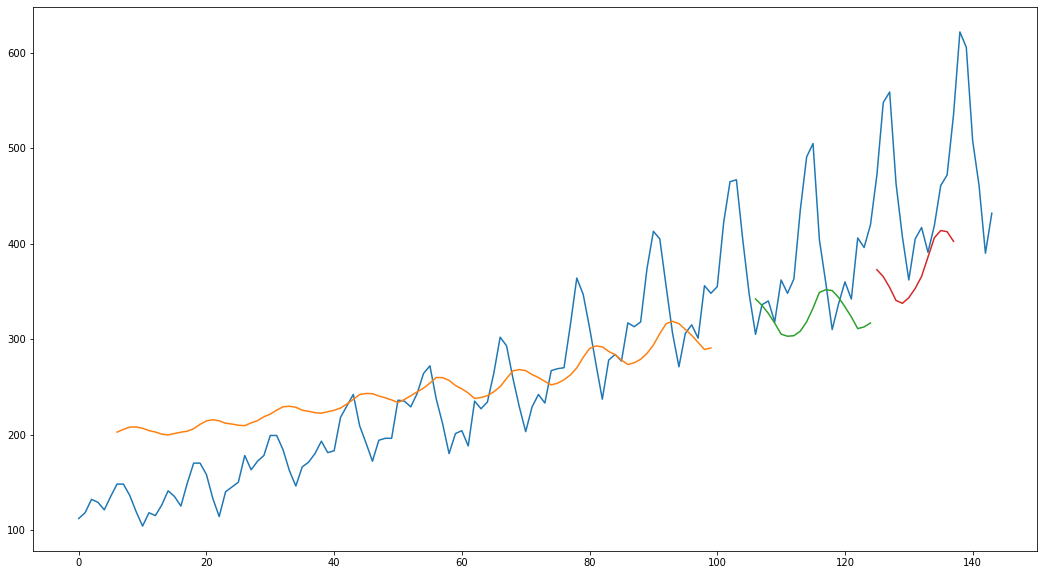

In [196]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(normalized_univariate_array)
train_predict_plot[:, :] = np.nan
# reshape in order to fill only the training examples
train_predict_plot[input_window_size:len(predictions_for_train_denormalized)+input_window_size, :] = predictions_for_train_denormalized

# shift validation predictions for plotting
validation_predict_plot = np.empty_like(normalized_univariate_array)
validation_predict_plot[:, :] = np.nan
validation_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized), :] = predictions_for_val_denormalized

# shift test predictions for plotting
test_predict_plot = np.empty_like(normalized_univariate_array)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized)+len(predictions_for_test_denormalized)] = predictions_for_test_denormalized


# plot baseline and predictions
fig = plt.figure(figsize=(18, 10))
plt.plot(scaler.inverse_transform(normalized_univariate_array))
plt.plot(train_predict_plot)
plt.plot(validation_predict_plot)
plt.plot(test_predict_plot)
plt.show()

## Let's lower the executions_per_trail parameter to 1

In [197]:
approach = "univariate"

# training & hyperparameter tuning
LOG_DIR = f"{int((time.time()))}"

tuner = RandomSearch(
        build_modified_model,
        objective="val_mean_absolute_error", # evtl. RMSE
        max_trials= 5,
        executions_per_trial=1,
        directory='one_step_univariate/tuning_logs',
        project_name=LOG_DIR
    )
    
tuner.search(
    x=train_samples[0],
    y=train_samples[1],
    epochs=100,
    batch_size=32,
    validation_data=(val_samples[0], val_samples[1]),
    callbacks=[EarlyStopping('val_loss', patience=5)])
    
# get best model
model = tuner.get_best_models(num_models=1)[0]
model.save(f"../models/modified_architecture_{approach}_{input_window_size}")

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0850 - mean_absolute_error: 0.255 - 1s 13ms/sample - loss: 0.0713 - mean_absolute_error: 0.2256 - val_loss: 0.2490 - val_mean_absolute_error: 0.4876
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0560 - mean_absolute_error: 0.198 - 0s 387us/sample - loss: 0.0528 - mean_absolute_error: 0.1871 - val_loss: 0.2073 - val_mean_absolute_error: 0.4428
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0557 - mean_absolute_error: 0.199 - 0s 365us/sample - loss: 0.0388 - mean_absolute_error: 0.1530 - val_loss: 0.1627 - val_mean_absolute_error: 0.3892
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.130 - 0s 357us/sample - loss: 0.0257 - mean_absolute_error: 0.1239 - val_loss: 0.1156 - val_mean_absolute_error: 0.3229
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.02

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0605 - mean_absolute_error: 0.208 - 1s 10ms/sample - loss: 0.0681 - mean_absolute_error: 0.2226 - val_loss: 0.2521 - val_mean_absolute_error: 0.4908
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0586 - mean_absolute_error: 0.200 - 0s 318us/sample - loss: 0.0592 - mean_absolute_error: 0.2040 - val_loss: 0.2257 - val_mean_absolute_error: 0.4629
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0564 - mean_absolute_error: 0.188 - 0s 341us/sample - loss: 0.0512 - mean_absolute_error: 0.1866 - val_loss: 0.2010 - val_mean_absolute_error: 0.4353
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.152 - 0s 274us/sample - loss: 0.0438 - mean_absolute_error: 0.1703 - val_loss: 0.1782 - val_mean_absolute_error: 0.4083
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.02

Epoch 38/100
94/94 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.054 - 0s 243us/sample - loss: 0.0046 - mean_absolute_error: 0.0536 - val_loss: 0.0159 - val_mean_absolute_error: 0.1037
Epoch 39/100
94/94 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.055 - 0s 227us/sample - loss: 0.0045 - mean_absolute_error: 0.0533 - val_loss: 0.0159 - val_mean_absolute_error: 0.1039
Epoch 40/100
94/94 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.061 - 0s 217us/sample - loss: 0.0045 - mean_absolute_error: 0.0534 - val_loss: 0.0159 - val_mean_absolute_error: 0.1042
Epoch 41/100
94/94 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.057 - 0s 194us/sample - loss: 0.0045 - mean_absolute_error: 0.0533 - val_loss: 0.0158 - val_mean_absolute_error: 0.1041
Epoch 42/100
94/94 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.052 - 0s 2

Epoch 75/100
94/94 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.049 - 0s 273us/sample - loss: 0.0040 - mean_absolute_error: 0.0497 - val_loss: 0.0145 - val_mean_absolute_error: 0.0946
Epoch 76/100
94/94 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.044 - 0s 266us/sample - loss: 0.0040 - mean_absolute_error: 0.0495 - val_loss: 0.0145 - val_mean_absolute_error: 0.0943
Epoch 77/100
94/94 [==============================] - ETA: 0s - loss: 0.0022 - mean_absolute_error: 0.038 - 0s 290us/sample - loss: 0.0040 - mean_absolute_error: 0.0494 - val_loss: 0.0144 - val_mean_absolute_error: 0.0941
Epoch 78/100
94/94 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.057 - 0s 296us/sample - loss: 0.0040 - mean_absolute_error: 0.0494 - val_loss: 0.0143 - val_mean_absolute_error: 0.0940
Epoch 79/100
94/94 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.044 - 0s 2

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0623 - mean_absolute_error: 0.217 - 1s 11ms/sample - loss: 0.0634 - mean_absolute_error: 0.2144 - val_loss: 0.2343 - val_mean_absolute_error: 0.4723
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0592 - mean_absolute_error: 0.203 - 0s 305us/sample - loss: 0.0555 - mean_absolute_error: 0.1968 - val_loss: 0.2122 - val_mean_absolute_error: 0.4483
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0516 - mean_absolute_error: 0.184 - 0s 355us/sample - loss: 0.0483 - mean_absolute_error: 0.1806 - val_loss: 0.1911 - val_mean_absolute_error: 0.4241
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0418 - mean_absolute_error: 0.163 - 0s 349us/sample - loss: 0.0416 - mean_absolute_error: 0.1648 - val_loss: 0.1711 - val_mean_absolute_error: 0.3997
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.03

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 2s - loss: 0.0678 - mean_absolute_error: 0.222 - 1s 14ms/sample - loss: 0.0737 - mean_absolute_error: 0.2322 - val_loss: 0.2759 - val_mean_absolute_error: 0.5144
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0826 - mean_absolute_error: 0.258 - 0s 357us/sample - loss: 0.0658 - mean_absolute_error: 0.2153 - val_loss: 0.2540 - val_mean_absolute_error: 0.4928
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0490 - mean_absolute_error: 0.170 - 0s 366us/sample - loss: 0.0570 - mean_absolute_error: 0.1970 - val_loss: 0.2298 - val_mean_absolute_error: 0.4675
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0521 - mean_absolute_error: 0.193 - 0s 363us/sample - loss: 0.0489 - mean_absolute_error: 0.1790 - val_loss: 0.2040 - val_mean_absolute_error: 0.4390
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.03

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0851 - mean_absolute_error: 0.253 - 1s 10ms/sample - loss: 0.0681 - mean_absolute_error: 0.2224 - val_loss: 0.2502 - val_mean_absolute_error: 0.4890
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0708 - mean_absolute_error: 0.232 - 0s 263us/sample - loss: 0.0592 - mean_absolute_error: 0.2042 - val_loss: 0.2246 - val_mean_absolute_error: 0.4621
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0451 - mean_absolute_error: 0.170 - 0s 282us/sample - loss: 0.0512 - mean_absolute_error: 0.1880 - val_loss: 0.2025 - val_mean_absolute_error: 0.4375
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0525 - mean_absolute_error: 0.184 - 0s 260us/sample - loss: 0.0453 - mean_absolute_error: 0.1740 - val_loss: 0.1821 - val_mean_absolute_error: 0.4134
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.04

Epoch 38/100
94/94 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.049 - 0s 277us/sample - loss: 0.0042 - mean_absolute_error: 0.0510 - val_loss: 0.0148 - val_mean_absolute_error: 0.0986
Epoch 39/100
94/94 [==============================] - ETA: 0s - loss: 0.0035 - mean_absolute_error: 0.049 - 0s 284us/sample - loss: 0.0042 - mean_absolute_error: 0.0509 - val_loss: 0.0148 - val_mean_absolute_error: 0.0982
Epoch 40/100
94/94 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.058 - 0s 270us/sample - loss: 0.0041 - mean_absolute_error: 0.0510 - val_loss: 0.0147 - val_mean_absolute_error: 0.0982
Epoch 41/100
94/94 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.049 - 0s 267us/sample - loss: 0.0041 - mean_absolute_error: 0.0507 - val_loss: 0.0147 - val_mean_absolute_error: 0.0979
Epoch 42/100
94/94 [==============================] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.036 - 0s 2

Epoch 75/100
94/94 [==============================] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.040 - 0s 284us/sample - loss: 0.0036 - mean_absolute_error: 0.0468 - val_loss: 0.0126 - val_mean_absolute_error: 0.0868
Epoch 76/100
94/94 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.045 - 0s 297us/sample - loss: 0.0036 - mean_absolute_error: 0.0467 - val_loss: 0.0125 - val_mean_absolute_error: 0.0865
Epoch 77/100
94/94 [==============================] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.048 - 0s 248us/sample - loss: 0.0036 - mean_absolute_error: 0.0467 - val_loss: 0.0124 - val_mean_absolute_error: 0.0865
Epoch 78/100
94/94 [==============================] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.042 - 0s 243us/sample - loss: 0.0036 - mean_absolute_error: 0.0465 - val_loss: 0.0123 - val_mean_absolute_error: 0.0861
Epoch 79/100
94/94 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.047 - 0s 3

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ../models/modified_architecture_univariate_6/assets


In [198]:
# make predictions
predictions_for_train = model.predict(train_samples[0])
predictions_for_validation = model.predict(val_samples[0])
predictions_for_test = model.predict(test_samples[0])
predictions_for_test

# invert predictions
predictions_for_train_denormalized = scaler.inverse_transform(predictions_for_train)
true_values_train = scaler.inverse_transform(train_samples[1])

predictions_for_val_denormalized = scaler.inverse_transform(predictions_for_validation)
true_values_val = scaler.inverse_transform(val_samples[1])

predictions_for_test_denormalized = scaler.inverse_transform(predictions_for_test)
true_values_test = scaler.inverse_transform(test_samples[1])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(true_values_train, predictions_for_train_denormalized))
print('Train Score: %.2f RMSE' % (train_score))

validation_score = math.sqrt(mean_squared_error(true_values_val, predictions_for_val_denormalized))
print('Validation Score: %.2f RMSE' % (validation_score))

test_score = math.sqrt(mean_squared_error(true_values_test, predictions_for_test_denormalized))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 30.02 RMSE
Validation Score: 54.72 RMSE
Test Score: 78.41 RMSE


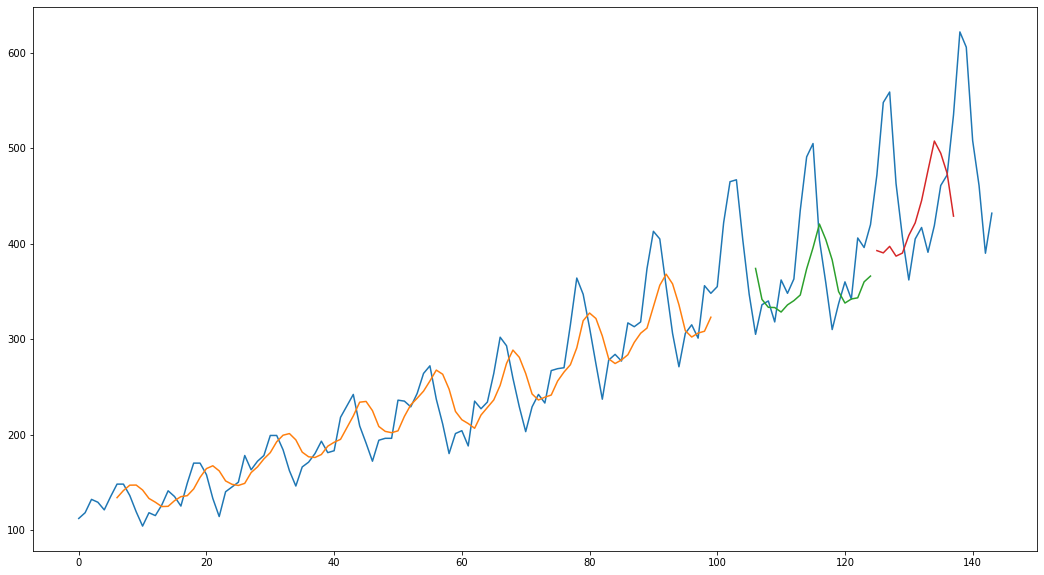

In [199]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(normalized_univariate_array)
train_predict_plot[:, :] = np.nan
# reshape in order to fill only the training examples
train_predict_plot[input_window_size:len(predictions_for_train_denormalized)+input_window_size, :] = predictions_for_train_denormalized

# shift validation predictions for plotting
validation_predict_plot = np.empty_like(normalized_univariate_array)
validation_predict_plot[:, :] = np.nan
validation_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized), :] = predictions_for_val_denormalized

# shift test predictions for plotting
test_predict_plot = np.empty_like(normalized_univariate_array)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized)+len(predictions_for_test_denormalized)] = predictions_for_test_denormalized


# plot baseline and predictions
fig = plt.figure(figsize=(18, 10))
plt.plot(scaler.inverse_transform(normalized_univariate_array))
plt.plot(train_predict_plot)
plt.plot(validation_predict_plot)
plt.plot(test_predict_plot)
plt.show()

## Let's try out this new architecture with input window size of 12 months

In [200]:
input_window_size = 12
output_window_size = 1

train_samples, val_samples, test_samples = create_samples(train_set, validation_set, test_set, input_window_size, output_window_size)

Number of training samples: 88, validation samples: 13, test samples: 7


In [201]:
approach = "univariate"

# training & hyperparameter tuning
LOG_DIR = f"{int((time.time()))}"

tuner = RandomSearch(
        build_modified_model,
        objective="val_mean_absolute_error", # evtl. RMSE
        max_trials= 5,
        executions_per_trial=1,
        directory='one_step_univariate/tuning_logs',
        project_name=LOG_DIR
    )
    
tuner.search(
    x=train_samples[0],
    y=train_samples[1],
    epochs=100,
    batch_size=32,
    validation_data=(val_samples[0], val_samples[1]),
    callbacks=[EarlyStopping('val_loss', patience=5)])
    
# get best model
model = tuner.get_best_models(num_models=1)[0]
model.save(f"../models/modified_architecture_{approach}_{input_window_size}")

Train on 88 samples, validate on 13 samples
Epoch 1/100
88/88 [==============================] - ETA: 1s - loss: 0.0800 - mean_absolute_error: 0.254 - 1s 13ms/sample - loss: 0.0493 - mean_absolute_error: 0.1841 - val_loss: 0.1103 - val_mean_absolute_error: 0.3136
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.0178 - mean_absolute_error: 0.095 - 0s 422us/sample - loss: 0.0122 - mean_absolute_error: 0.0821 - val_loss: 0.0138 - val_mean_absolute_error: 0.0918
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.097 - 0s 346us/sample - loss: 0.0159 - mean_absolute_error: 0.1113 - val_loss: 0.0167 - val_mean_absolute_error: 0.0998
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.088 - 0s 292us/sample - loss: 0.0091 - mean_absolute_error: 0.0797 - val_loss: 0.0481 - val_mean_absolute_error: 0.1888
Epoch 5/100
88/88 [==============================] - ETA: 0s - loss: 0.00

Train on 88 samples, validate on 13 samples
Epoch 1/100
88/88 [==============================] - ETA: 1s - loss: 0.0529 - mean_absolute_error: 0.211 - 1s 11ms/sample - loss: 0.0733 - mean_absolute_error: 0.2369 - val_loss: 0.3058 - val_mean_absolute_error: 0.5425
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.0899 - mean_absolute_error: 0.263 - 0s 404us/sample - loss: 0.0726 - mean_absolute_error: 0.2354 - val_loss: 0.3036 - val_mean_absolute_error: 0.5405
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.213 - 0s 412us/sample - loss: 0.0718 - mean_absolute_error: 0.2340 - val_loss: 0.3015 - val_mean_absolute_error: 0.5385
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.0632 - mean_absolute_error: 0.223 - 0s 356us/sample - loss: 0.0711 - mean_absolute_error: 0.2326 - val_loss: 0.2993 - val_mean_absolute_error: 0.5365
Epoch 5/100
88/88 [==============================] - ETA: 0s - loss: 0.05

Epoch 38/100
88/88 [==============================] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.156 - 0s 450us/sample - loss: 0.0467 - mean_absolute_error: 0.1794 - val_loss: 0.2222 - val_mean_absolute_error: 0.4588
Epoch 39/100
88/88 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.154 - 0s 453us/sample - loss: 0.0460 - mean_absolute_error: 0.1777 - val_loss: 0.2198 - val_mean_absolute_error: 0.4562
Epoch 40/100
88/88 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.151 - 0s 396us/sample - loss: 0.0453 - mean_absolute_error: 0.1759 - val_loss: 0.2175 - val_mean_absolute_error: 0.4536
Epoch 41/100
88/88 [==============================] - ETA: 0s - loss: 0.0492 - mean_absolute_error: 0.187 - 0s 431us/sample - loss: 0.0446 - mean_absolute_error: 0.1742 - val_loss: 0.2151 - val_mean_absolute_error: 0.4510
Epoch 42/100
88/88 [==============================] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.159 - 0s 4

Epoch 75/100
88/88 [==============================] - ETA: 0s - loss: 0.0229 - mean_absolute_error: 0.113 - 0s 439us/sample - loss: 0.0213 - mean_absolute_error: 0.1105 - val_loss: 0.1251 - val_mean_absolute_error: 0.3362
Epoch 76/100
88/88 [==============================] - ETA: 0s - loss: 0.0162 - mean_absolute_error: 0.096 - 0s 398us/sample - loss: 0.0206 - mean_absolute_error: 0.1086 - val_loss: 0.1221 - val_mean_absolute_error: 0.3316
Epoch 77/100
88/88 [==============================] - ETA: 0s - loss: 0.0245 - mean_absolute_error: 0.123 - 0s 371us/sample - loss: 0.0200 - mean_absolute_error: 0.1066 - val_loss: 0.1191 - val_mean_absolute_error: 0.3271
Epoch 78/100
88/88 [==============================] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.080 - 0s 366us/sample - loss: 0.0193 - mean_absolute_error: 0.1045 - val_loss: 0.1161 - val_mean_absolute_error: 0.3225
Epoch 79/100
88/88 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.124 - 0s 3

Train on 88 samples, validate on 13 samples
Epoch 1/100
88/88 [==============================] - ETA: 1s - loss: 0.0537 - mean_absolute_error: 0.196 - 1s 13ms/sample - loss: 0.0660 - mean_absolute_error: 0.2239 - val_loss: 0.2425 - val_mean_absolute_error: 0.4801
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.191 - 0s 348us/sample - loss: 0.0501 - mean_absolute_error: 0.1888 - val_loss: 0.1900 - val_mean_absolute_error: 0.4217
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.0452 - mean_absolute_error: 0.175 - 0s 377us/sample - loss: 0.0365 - mean_absolute_error: 0.1556 - val_loss: 0.1455 - val_mean_absolute_error: 0.3649
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.0231 - mean_absolute_error: 0.121 - 0s 400us/sample - loss: 0.0244 - mean_absolute_error: 0.1226 - val_loss: 0.1007 - val_mean_absolute_error: 0.2968
Epoch 5/100
88/88 [==============================] - ETA: 0s - loss: 0.02

Train on 88 samples, validate on 13 samples
Epoch 1/100
88/88 [==============================] - ETA: 1s - loss: 0.0931 - mean_absolute_error: 0.273 - 1s 11ms/sample - loss: 0.0921 - mean_absolute_error: 0.2658 - val_loss: 0.3672 - val_mean_absolute_error: 0.5962
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.0977 - mean_absolute_error: 0.270 - 0s 340us/sample - loss: 0.0821 - mean_absolute_error: 0.2477 - val_loss: 0.3369 - val_mean_absolute_error: 0.5702
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.0580 - mean_absolute_error: 0.208 - 0s 409us/sample - loss: 0.0726 - mean_absolute_error: 0.2302 - val_loss: 0.3081 - val_mean_absolute_error: 0.5443
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.0656 - mean_absolute_error: 0.220 - 0s 365us/sample - loss: 0.0642 - mean_absolute_error: 0.2135 - val_loss: 0.2800 - val_mean_absolute_error: 0.5178
Epoch 5/100
88/88 [==============================] - ETA: 0s - loss: 0.05

Train on 88 samples, validate on 13 samples
Epoch 1/100
88/88 [==============================] - ETA: 1s - loss: 0.0624 - mean_absolute_error: 0.221 - 1s 11ms/sample - loss: 0.0636 - mean_absolute_error: 0.2189 - val_loss: 0.2337 - val_mean_absolute_error: 0.4710
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 0.0439 - mean_absolute_error: 0.178 - 0s 358us/sample - loss: 0.0476 - mean_absolute_error: 0.1836 - val_loss: 0.1813 - val_mean_absolute_error: 0.4115
Epoch 3/100
88/88 [==============================] - ETA: 0s - loss: 0.0425 - mean_absolute_error: 0.173 - 0s 349us/sample - loss: 0.0332 - mean_absolute_error: 0.1467 - val_loss: 0.1308 - val_mean_absolute_error: 0.3443
Epoch 4/100
88/88 [==============================] - ETA: 0s - loss: 0.0215 - mean_absolute_error: 0.112 - 0s 307us/sample - loss: 0.0214 - mean_absolute_error: 0.1136 - val_loss: 0.0894 - val_mean_absolute_error: 0.2772
Epoch 5/100
88/88 [==============================] - ETA: 0s - loss: 0.01

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ../models/modified_architecture_univariate_12/assets


In [202]:
# make predictions
predictions_for_train = model.predict(train_samples[0])
predictions_for_validation = model.predict(val_samples[0])
predictions_for_test = model.predict(test_samples[0])
predictions_for_test

# invert predictions
predictions_for_train_denormalized = scaler.inverse_transform(predictions_for_train)
true_values_train = scaler.inverse_transform(train_samples[1])

predictions_for_val_denormalized = scaler.inverse_transform(predictions_for_validation)
true_values_val = scaler.inverse_transform(val_samples[1])

predictions_for_test_denormalized = scaler.inverse_transform(predictions_for_test)
true_values_test = scaler.inverse_transform(test_samples[1])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(true_values_train, predictions_for_train_denormalized))
print('Train Score: %.2f RMSE' % (train_score))

validation_score = math.sqrt(mean_squared_error(true_values_val, predictions_for_val_denormalized))
print('Validation Score: %.2f RMSE' % (validation_score))

test_score = math.sqrt(mean_squared_error(true_values_test, predictions_for_test_denormalized))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 61.83 RMSE
Validation Score: 60.79 RMSE
Test Score: 109.79 RMSE


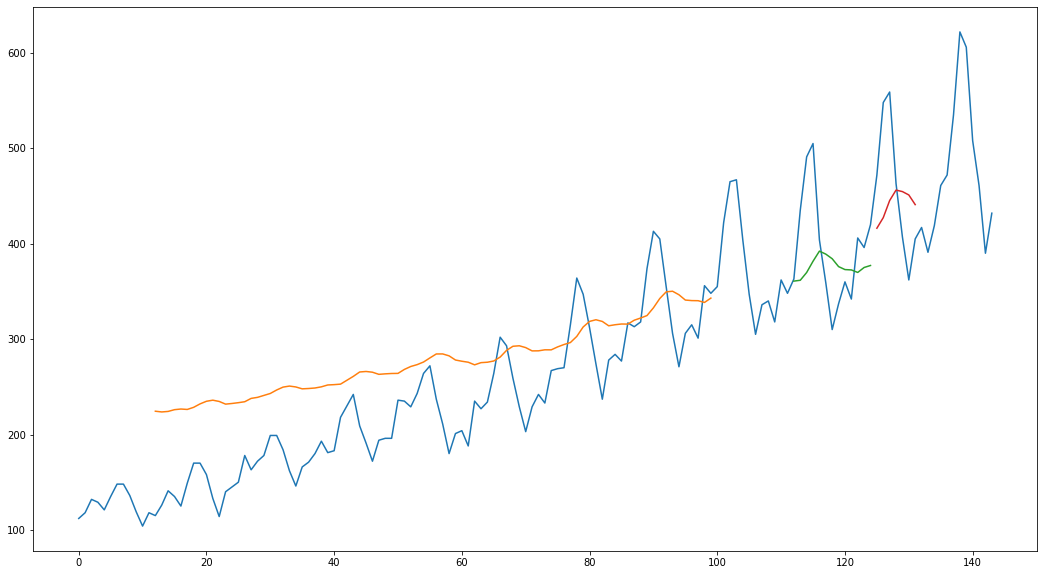

In [203]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(normalized_univariate_array)
train_predict_plot[:, :] = np.nan
# reshape in order to fill only the training examples
train_predict_plot[input_window_size:len(predictions_for_train_denormalized)+input_window_size, :] = predictions_for_train_denormalized

# shift validation predictions for plotting
validation_predict_plot = np.empty_like(normalized_univariate_array)
validation_predict_plot[:, :] = np.nan
validation_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized), :] = predictions_for_val_denormalized

# shift test predictions for plotting
test_predict_plot = np.empty_like(normalized_univariate_array)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized)+len(predictions_for_test_denormalized)] = predictions_for_test_denormalized


# plot baseline and predictions
fig = plt.figure(figsize=(18, 10))
plt.plot(scaler.inverse_transform(normalized_univariate_array))
plt.plot(train_predict_plot)
plt.plot(validation_predict_plot)
plt.plot(test_predict_plot)
plt.show()

## It looks like the network is unable to model seasonality. Let's try allocating more neurons per layer.

In [208]:
input_window_size = 6
output_window_size = 1

train_samples, val_samples, test_samples = create_samples(train_set, validation_set, test_set, input_window_size, output_window_size)

Number of training samples: 94, validation samples: 19, test samples: 13


In [209]:
def build_bigger_model(hp):
    model = Sequential()
    # input LSTM layer
    model.add(LSTM(hp.Int("input_units", min_value=5, max_value=100, step=5),
                   activation='relu', input_shape=(input_window_size, 1), name="lstm"))
    
    # dense hidden layers with dropouts
    for i in range(hp.Int("n_layers", 0,2)):
        model.add(Dense(hp.Int(f"dense_{i}_units", min_value=5, max_value=100, step=5),
                        activation='relu', name=f"hidden_{i}"))    
    # dense output layer
    model.add(Dense(1, name="output"))
    model.compile(loss='mean_squared_error' , optimizer=Adam(learning_rate=
            hp.Choice("learning_rate",values=[1e-2, 1e-3, 1e-4])), metrics=[metrics.mae])
    return model

In [210]:
approach = "univariate"

# training & hyperparameter tuning
LOG_DIR = f"{int((time.time()))}"

tuner = RandomSearch(
        build_bigger_model,
        objective="val_mean_absolute_error", # evtl. RMSE
        max_trials= 5,
        executions_per_trial=1,
        directory='one_step_univariate/tuning_logs',
        project_name=LOG_DIR
    )
    
tuner.search(
    x=train_samples[0],
    y=train_samples[1],
    epochs=100,
    batch_size=32,
    validation_data=(val_samples[0], val_samples[1]),
    callbacks=[EarlyStopping('val_loss', patience=5)])
    
# get best model
model = tuner.get_best_models(num_models=1)[0]
model.save(f"../models/modified_architecture_{approach}_{input_window_size}")

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0896 - mean_absolute_error: 0.276 - 1s 11ms/sample - loss: 0.0730 - mean_absolute_error: 0.2318 - val_loss: 0.2847 - val_mean_absolute_error: 0.5230
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0716 - mean_absolute_error: 0.234 - 0s 305us/sample - loss: 0.0729 - mean_absolute_error: 0.2314 - val_loss: 0.2842 - val_mean_absolute_error: 0.5225
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0650 - mean_absolute_error: 0.213 - 0s 339us/sample - loss: 0.0727 - mean_absolute_error: 0.2310 - val_loss: 0.2838 - val_mean_absolute_error: 0.5220
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0565 - mean_absolute_error: 0.202 - 0s 312us/sample - loss: 0.0725 - mean_absolute_error: 0.2306 - val_loss: 0.2833 - val_mean_absolute_error: 0.5216
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.07

Epoch 34/100
94/94 [==============================] - ETA: 0s - loss: 0.0446 - mean_absolute_error: 0.177 - 0s 323us/sample - loss: 0.0653 - mean_absolute_error: 0.2156 - val_loss: 0.2641 - val_mean_absolute_error: 0.5029
Epoch 35/100
94/94 [==============================] - ETA: 0s - loss: 0.0803 - mean_absolute_error: 0.233 - 0s 355us/sample - loss: 0.0651 - mean_absolute_error: 0.2150 - val_loss: 0.2634 - val_mean_absolute_error: 0.5021
Epoch 36/100
94/94 [==============================] - ETA: 0s - loss: 0.0630 - mean_absolute_error: 0.199 - 0s 347us/sample - loss: 0.0648 - mean_absolute_error: 0.2145 - val_loss: 0.2626 - val_mean_absolute_error: 0.5013
Epoch 37/100
94/94 [==============================] - ETA: 0s - loss: 0.0589 - mean_absolute_error: 0.201 - 0s 318us/sample - loss: 0.0645 - mean_absolute_error: 0.2139 - val_loss: 0.2619 - val_mean_absolute_error: 0.5006
Epoch 38/100
94/94 [==============================] - ETA: 0s - loss: 0.0804 - mean_absolute_error: 0.239 - 0s 3

Epoch 71/100
94/94 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.148 - 0s 362us/sample - loss: 0.0520 - mean_absolute_error: 0.1865 - val_loss: 0.2244 - val_mean_absolute_error: 0.4615
Epoch 72/100
94/94 [==============================] - ETA: 0s - loss: 0.0454 - mean_absolute_error: 0.171 - 0s 348us/sample - loss: 0.0514 - mean_absolute_error: 0.1853 - val_loss: 0.2227 - val_mean_absolute_error: 0.4596
Epoch 73/100
94/94 [==============================] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.160 - 0s 325us/sample - loss: 0.0509 - mean_absolute_error: 0.1841 - val_loss: 0.2211 - val_mean_absolute_error: 0.4578
Epoch 74/100
94/94 [==============================] - ETA: 0s - loss: 0.0437 - mean_absolute_error: 0.171 - 0s 284us/sample - loss: 0.0504 - mean_absolute_error: 0.1830 - val_loss: 0.2195 - val_mean_absolute_error: 0.4561
Epoch 75/100
94/94 [==============================] - ETA: 0s - loss: 0.0626 - mean_absolute_error: 0.211 - 0s 2

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0794 - mean_absolute_error: 0.247 - 1s 11ms/sample - loss: 0.0444 - mean_absolute_error: 0.1672 - val_loss: 0.0308 - val_mean_absolute_error: 0.1386
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.090 - 0s 312us/sample - loss: 0.0170 - mean_absolute_error: 0.1130 - val_loss: 0.0202 - val_mean_absolute_error: 0.1066
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0118 - mean_absolute_error: 0.095 - 0s 249us/sample - loss: 0.0098 - mean_absolute_error: 0.0808 - val_loss: 0.0601 - val_mean_absolute_error: 0.2187
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0121 - mean_absolute_error: 0.081 - 0s 219us/sample - loss: 0.0111 - mean_absolute_error: 0.0781 - val_loss: 0.0371 - val_mean_absolute_error: 0.1593
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.00

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0858 - mean_absolute_error: 0.252 - 1s 9ms/sample - loss: 0.0512 - mean_absolute_error: 0.1795 - val_loss: 0.0539 - val_mean_absolute_error: 0.2023
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.086 - 0s 259us/sample - loss: 0.0152 - mean_absolute_error: 0.1055 - val_loss: 0.0165 - val_mean_absolute_error: 0.1003
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.100 - 0s 223us/sample - loss: 0.0114 - mean_absolute_error: 0.0874 - val_loss: 0.0495 - val_mean_absolute_error: 0.1924
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.095 - 0s 197us/sample - loss: 0.0106 - mean_absolute_error: 0.0798 - val_loss: 0.0513 - val_mean_absolute_error: 0.1974
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.010

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0636 - mean_absolute_error: 0.214 - 1s 9ms/sample - loss: 0.0766 - mean_absolute_error: 0.2369 - val_loss: 0.2843 - val_mean_absolute_error: 0.5225
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0500 - mean_absolute_error: 0.194 - 0s 252us/sample - loss: 0.0666 - mean_absolute_error: 0.2176 - val_loss: 0.2558 - val_mean_absolute_error: 0.4944
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0438 - mean_absolute_error: 0.179 - 0s 289us/sample - loss: 0.0579 - mean_absolute_error: 0.2000 - val_loss: 0.2292 - val_mean_absolute_error: 0.4669
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0318 - mean_absolute_error: 0.142 - 0s 257us/sample - loss: 0.0500 - mean_absolute_error: 0.1825 - val_loss: 0.2055 - val_mean_absolute_error: 0.4406
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.036

Train on 94 samples, validate on 19 samples
Epoch 1/100
94/94 [==============================] - ETA: 1s - loss: 0.0630 - mean_absolute_error: 0.227 - 1s 9ms/sample - loss: 0.0696 - mean_absolute_error: 0.2262 - val_loss: 0.2703 - val_mean_absolute_error: 0.5091
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.187 - 0s 236us/sample - loss: 0.0692 - mean_absolute_error: 0.2254 - val_loss: 0.2693 - val_mean_absolute_error: 0.5082
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.0544 - mean_absolute_error: 0.198 - 0s 268us/sample - loss: 0.0689 - mean_absolute_error: 0.2246 - val_loss: 0.2683 - val_mean_absolute_error: 0.5071
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.0496 - mean_absolute_error: 0.198 - 0s 232us/sample - loss: 0.0684 - mean_absolute_error: 0.2237 - val_loss: 0.2671 - val_mean_absolute_error: 0.5060
Epoch 5/100
94/94 [==============================] - ETA: 0s - loss: 0.066

Epoch 38/100
94/94 [==============================] - ETA: 0s - loss: 0.0545 - mean_absolute_error: 0.184 - 0s 236us/sample - loss: 0.0538 - mean_absolute_error: 0.1918 - val_loss: 0.2265 - val_mean_absolute_error: 0.4640
Epoch 39/100
94/94 [==============================] - ETA: 0s - loss: 0.0470 - mean_absolute_error: 0.177 - 0s 255us/sample - loss: 0.0534 - mean_absolute_error: 0.1909 - val_loss: 0.2253 - val_mean_absolute_error: 0.4628
Epoch 40/100
94/94 [==============================] - ETA: 0s - loss: 0.0503 - mean_absolute_error: 0.186 - 0s 281us/sample - loss: 0.0530 - mean_absolute_error: 0.1901 - val_loss: 0.2242 - val_mean_absolute_error: 0.4616
Epoch 41/100
94/94 [==============================] - ETA: 0s - loss: 0.0523 - mean_absolute_error: 0.193 - 0s 245us/sample - loss: 0.0526 - mean_absolute_error: 0.1892 - val_loss: 0.2231 - val_mean_absolute_error: 0.4603
Epoch 42/100
94/94 [==============================] - ETA: 0s - loss: 0.0607 - mean_absolute_error: 0.212 - 0s 2

Epoch 75/100
94/94 [==============================] - ETA: 0s - loss: 0.0438 - mean_absolute_error: 0.170 - 0s 250us/sample - loss: 0.0407 - mean_absolute_error: 0.1612 - val_loss: 0.1866 - val_mean_absolute_error: 0.4188
Epoch 76/100
94/94 [==============================] - ETA: 0s - loss: 0.0438 - mean_absolute_error: 0.168 - 0s 253us/sample - loss: 0.0404 - mean_absolute_error: 0.1604 - val_loss: 0.1855 - val_mean_absolute_error: 0.4175
Epoch 77/100
94/94 [==============================] - ETA: 0s - loss: 0.0425 - mean_absolute_error: 0.156 - 0s 280us/sample - loss: 0.0401 - mean_absolute_error: 0.1596 - val_loss: 0.1845 - val_mean_absolute_error: 0.4163
Epoch 78/100
94/94 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.155 - 0s 250us/sample - loss: 0.0397 - mean_absolute_error: 0.1588 - val_loss: 0.1835 - val_mean_absolute_error: 0.4151
Epoch 79/100
94/94 [==============================] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.144 - 0s 2

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ../models/modified_architecture_univariate_6/assets


In [211]:
# make predictions
predictions_for_train = model.predict(train_samples[0])
predictions_for_validation = model.predict(val_samples[0])
predictions_for_test = model.predict(test_samples[0])
predictions_for_test

# invert predictions
predictions_for_train_denormalized = scaler.inverse_transform(predictions_for_train)
true_values_train = scaler.inverse_transform(train_samples[1])

predictions_for_val_denormalized = scaler.inverse_transform(predictions_for_validation)
true_values_val = scaler.inverse_transform(val_samples[1])

predictions_for_test_denormalized = scaler.inverse_transform(predictions_for_test)
true_values_test = scaler.inverse_transform(test_samples[1])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(true_values_train, predictions_for_train_denormalized))
print('Train Score: %.2f RMSE' % (train_score))

validation_score = math.sqrt(mean_squared_error(true_values_val, predictions_for_val_denormalized))
print('Validation Score: %.2f RMSE' % (validation_score))

test_score = math.sqrt(mean_squared_error(true_values_test, predictions_for_test_denormalized))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 43.20 RMSE
Validation Score: 65.72 RMSE
Test Score: 95.87 RMSE


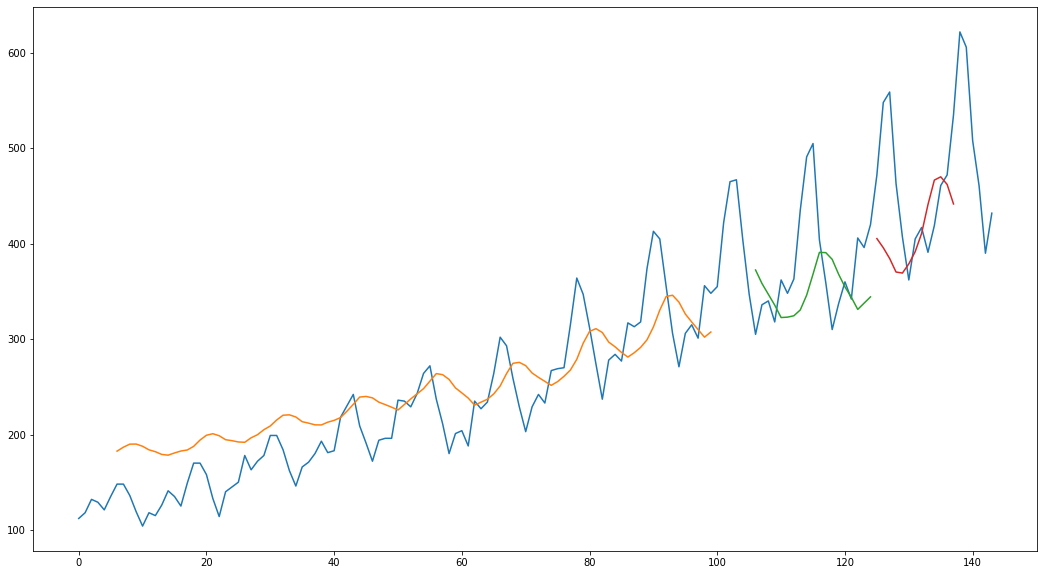

In [212]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(normalized_univariate_array)
train_predict_plot[:, :] = np.nan
# reshape in order to fill only the training examples
train_predict_plot[input_window_size:len(predictions_for_train_denormalized)+input_window_size, :] = predictions_for_train_denormalized

# shift validation predictions for plotting
validation_predict_plot = np.empty_like(normalized_univariate_array)
validation_predict_plot[:, :] = np.nan
validation_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized), :] = predictions_for_val_denormalized

# shift test predictions for plotting
test_predict_plot = np.empty_like(normalized_univariate_array)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized)+len(predictions_for_test_denormalized)] = predictions_for_test_denormalized


# plot baseline and predictions
fig = plt.figure(figsize=(18, 10))
plt.plot(scaler.inverse_transform(normalized_univariate_array))
plt.plot(train_predict_plot)
plt.plot(validation_predict_plot)
plt.plot(test_predict_plot)
plt.show()